In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples 
import matplotlib.cm as cm  
from pandas.plotting import parallel_coordinates
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram 
from sklearn.manifold import TSNE 
import umap
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import Counter  
from kmodes.kprototypes import KPrototypes   
import warnings
from matplotlib.pyplot import figure
warnings.filterwarnings("ignore")

In [2]:
#reading our clean dataset from data preparation part
df = pd.read_csv('clean_dataset.csv')

In [3]:
#defining categorical and numerical variables
num = df.iloc[:, :12].columns
cat = df.columns.drop(num).to_list()

In [4]:
num

Index(['Dayswus', 'Edu', 'Income', 'Recency', 'LTV', 'Dryred', 'Sweetred',
       'Drywh', 'Sweetwh', 'Dessert', 'Exotic', 'WebPurchase'],
      dtype='object')

## Outliers' Checking with DBSCAN

In [5]:
#computing the adequate values for DBSCAN parameters
min_points = len(num)* 2
k = min_points - 1

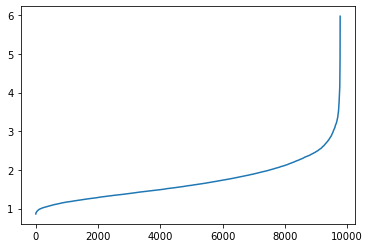

In [6]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(df[num])
distances, _ = neigh.kneighbors(df[num]) # distance of each observation to every k nearest neighbor
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [7]:
# Based on the hyperparameters found in the previous class
dbscan = DBSCAN(eps=2.6, min_samples=min_points, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[num])
Counter(dbscan_labels)

Counter({0: 9671, -1: 105})

In [8]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers
df = df[dbscan_labels!=-1].copy()

In [9]:
df.reset_index(inplace = True)

df.drop('index', axis = 1, inplace = True)

### Important Functions

In [10]:
def inertia_plot(clus_range, data): 
    range_clusters = np.arange(1,clus_range+1,1)
    inertia = []
    for n_clus in range_clusters:  
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=20, random_state=1)
        kmclust.fit(data)
        inertia.append(kmclust.inertia_) 
        
    # The inertia plot    
    plt.figure(figsize=(9,5))
    plt.plot(inertia)
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.title("Inertia plot over clusters", size=15) 
    plt.xticks(range(1,clus_range), range(1,clus_range))
    return plt.show() # returns inertia plot of k-means clustering algorithm

In [11]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=1
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

# Modeling

## Perspectives

In [12]:
df_copy = df.copy()

In [13]:
# Split variables into perspectives

#1st Perspective
customervalue_features = [
    'Income',
    'Recency',
    'LTV',
    'WebPurchase',
]


#2nd Perspective
bbehavior_features = [
    'Dryred', 
    'Sweetred', 
    'Drywh',
    'Sweetwh', 
    'Dessert', 
    'Exotic'
]

df_cv = df_copy[customervalue_features].copy()
df_bb = df_copy[bbehavior_features].copy()

## Perspective 1: Engagement (Customer Value)

### Algorithm 1: K-Means

In [14]:
df_cv

,Income,Recency,LTV,WebPurchase
0,0.288807,-0.832938,0.798753,-0.327499
1,1.260762,-0.497816,1.121804,-1.191971
2,-1.555072,0.016036,-0.754640,0.969210
3,-0.321997,-0.207378,-0.751204,0.915180
4,-0.174418,-1.168059,-0.716836,1.131298
...,...,...,...,...
9666,-1.012050,-0.497816,-0.789007,1.347416
9667,0.382300,0.083060,-0.087918,-0.813764
9668,0.516731,-0.229719,0.613171,-1.300030
9669,-1.099224,0.217109,-0.713400,0.861151


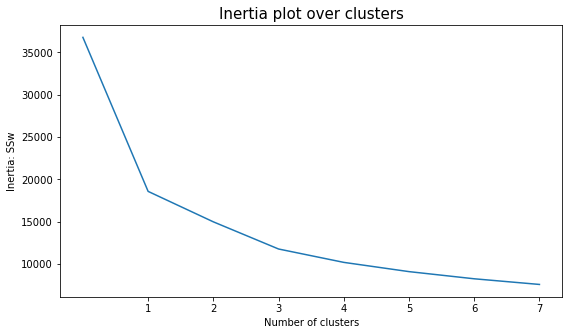

In [15]:
#analysing which is the right number of clusters we should extract
inertia_plot(8, df_cv)

In [16]:
# Obtaining the R² scores for each cluster solution on customer value variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_cv, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_cv, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.494884,0.079742,0.079742,0.000419,0.453261
3,0.592709,0.540331,0.512685,0.000634,0.542775
4,0.679986,0.566155,0.539547,0.000944,0.631570
5,0.722938,0.598836,0.539697,0.002473,0.681661
6,0.752658,0.686582,0.539951,0.002600,0.714956
7,0.775670,0.692408,0.656201,0.002873,0.738436
8,0.793852,0.710869,0.671694,0.003260,0.757444
9,0.808063,0.726256,0.673230,0.005500,0.772256


In [17]:
# cluster solution
number_clusters = 3
kmclust_cv = KMeans(n_clusters=number_clusters, init='k-means++', n_init=20, random_state=1)
km_labels_cv = kmclust_cv.fit_predict(df_cv)

#classyfing each cluster considering the data
real_labels_cv = km_labels_cv
mapping_cv = {0:'SilverCustomers', 1:'GoldCustomers', 2:'BronzeCustomers'}
real_labels_cv = [mapping_cv[i] for i in real_labels_cv]

#centroids
kmeans_cv = pd.concat((df_cv, pd.Series(real_labels_cv, name='labels')), axis=1)
kmeans_cv.groupby('labels').mean() 

,Income,Recency,LTV,WebPurchase
labels,,,,
BronzeCustomers,-0.885891,0.097404,-0.713138,0.803877
GoldCustomers,1.242066,-0.083858,1.526210,-1.307504
SilverCustomers,0.362940,-0.189514,-0.107040,-0.180505


In [18]:
#analysing the clusters' dimension
kmeans_cv['labels'].value_counts()

BronzeCustomers    4330
SilverCustomers    3064
GoldCustomers      2277
Name: labels, dtype: int64

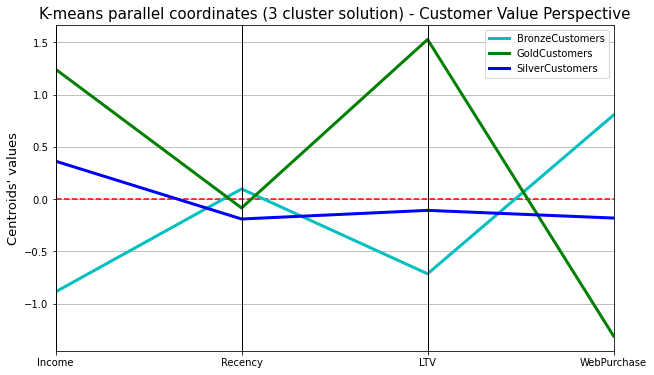

In [19]:
# parallel coordinates plot
finalkmeans_cv = kmeans_cv.groupby('labels').mean() 
finalkmeans_cv.reset_index(inplace=True)
plt.figure(figsize=(10,6))
parallel_coordinates(finalkmeans_cv, class_column='labels', cols=finalkmeans_cv.columns[1:], color=['c','g','b'], linewidth=3)  
plt.hlines(0, 0, 1000, colors="r", linestyles="dashed") # average value  
plt.ylabel("Centroids' values", fontsize=13)  
plt.title("K-means parallel coordinates (3 cluster solution) - Customer Value Perspective", fontsize=15) 
#plt.savefig('kmeans_customervalue.png', bbox_inches='tight') # save fig
plt.show()

### Algorithm 2: K-Prototypes

In [20]:
kproto_cv = df.copy()

In [21]:
kproto_cv.drop (bbehavior_features, axis = 1, inplace = True) #first perspective

#selecting the variables we want to exclude to proceed with this perspective (numeric - Edu and Dayswus) and 
#selecting the categorical variables we want to include in order to extract more information related to clusters' profiles
#but also with the aim of this perspective

kproto_cv.drop ('Edu', axis = 1, inplace = True)
kproto_cv.drop ('Dayswus', axis = 1, inplace = True)
kproto_cv.drop ('x0_18-37', axis = 1, inplace = True)
kproto_cv.drop ('x0_38-57', axis = 1, inplace = True)
kproto_cv.drop ('x0_58-78', axis = 1, inplace = True)

In [22]:
kproto_cv

,Income,Recency,LTV,WebPurchase,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless
0,0.288807,-0.832938,0.798753,-0.327499,0,0,0
1,1.260762,-0.497816,1.121804,-1.191971,0,0,0
2,-1.555072,0.016036,-0.754640,0.969210,1,1,1
3,-0.321997,-0.207378,-0.751204,0.915180,1,1,1
4,-0.174418,-1.168059,-0.716836,1.131298,1,1,1
...,...,...,...,...,...,...,...
9666,-1.012050,-0.497816,-0.789007,1.347416,1,1,1
9667,0.382300,0.083060,-0.087918,-0.813764,0,0,0
9668,0.516731,-0.229719,0.613171,-1.300030,0,0,0
9669,-1.099224,0.217109,-0.713400,0.861151,0,0,1


In [23]:
# cluster solution
number_clusters = 3
kpclust = KPrototypes(n_clusters=number_clusters, init='Huang', n_jobs=-1, random_state = 1) 
kp_labels = kpclust.fit_predict(kproto_cv, categorical=[4,5,6])

#classyfing each cluster considering the data
real_labels_cv = kp_labels
mapping_cv = {0:'BronzeCustomers', 1:'SilverCustomers', 2:'GoldCustomers'}
real_labels_cv = [mapping_cv[i] for i in real_labels_cv]


kpropotypescv = pd.concat((kproto_cv, pd.Series(real_labels_cv, name='labels')), axis=1) 
kpropotypescv.groupby('labels').mean() 

,Income,Recency,LTV,WebPurchase,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless
labels,,,,,,,
BronzeCustomers,-0.853099,0.073166,-0.719322,0.777523,0.801198,0.832039,0.915021
GoldCustomers,1.247463,-0.084770,1.541064,-1.321119,0.064458,0.000000,0.000000
SilverCustomers,0.396725,-0.167316,-0.048271,-0.205591,0.355631,0.115700,0.200683


In [24]:
kpropotypescv['labels'].value_counts()

BronzeCustomers    4507
SilverCustomers    2930
GoldCustomers      2234
Name: labels, dtype: int64

In [25]:
#defining a list with numeric variables from this perspective
num_cv = ['Income', 'Recency', 'LTV', 'WebPurchase' ]

In [26]:
# adaptation for r2 calculation
kpropotypes2_cv = pd.concat((kproto_cv[num_cv], pd.Series(kp_labels, name='labels')), axis=1) 
# r2 calculation
sst = get_ss(kpropotypes2_cv[num_cv])  # get total sum of squares
ssw_labels = kpropotypes2_cv.groupby('labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.5904922092586359

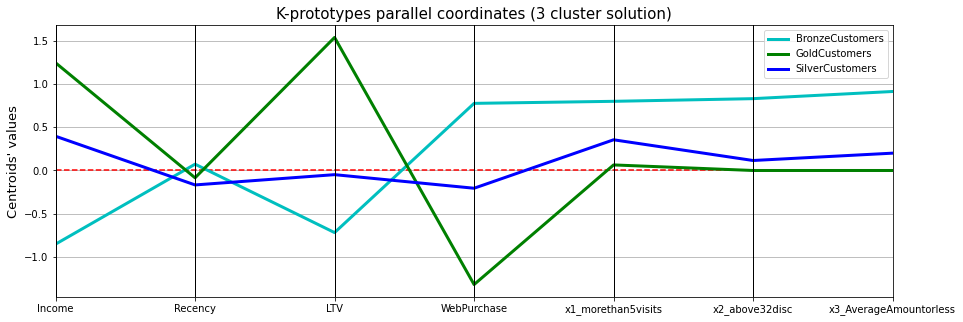

In [27]:
# parallel coordinates plot
kpropotypes_cv = pd.concat([kpropotypescv[num_cv], kpropotypescv.iloc[:,4:]], axis=1).groupby('labels').mean()    
kpropotypes_cv.reset_index(inplace=True)
plt.figure(figsize=(15,5))
parallel_coordinates(kpropotypes_cv, class_column='labels', cols=kpropotypes_cv.columns[1:], color=['c','g','b'], linewidth=3)  
plt.hlines(0, 0, 1000, colors="r", linestyles="dashed") # average value  
plt.ylabel("Centroids' values", fontsize=13)  
plt.title("K-prototypes parallel coordinates (3 cluster solution)", fontsize=15)  
plt.savefig('kprototypes_customervalue.png', bbox_inches='tight') # save fig
plt.show()

## Perspective 2: Buying Behavior

### Algorithm 1: K-Means

In [28]:
df_bb

,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
0,0.696886,-0.384691,-0.200649,-0.637531,-0.767261,-0.903412
1,-0.076832,-0.910301,1.389446,-0.766684,-0.502652,-0.962881
2,-2.011127,2.900373,-1.154705,3.237040,1.878831,1.891635
3,1.513589,-0.778899,-1.393219,-0.766684,-0.767261,2.307918
4,1.470605,-0.910301,-1.313715,-0.637531,-0.767261,0.702253
...,...,...,...,...,...,...
9666,0.954792,-0.778899,-0.280153,-0.766684,-0.899566,-0.546597
9667,1.169714,-0.910301,-0.677677,-0.766684,-0.767261,-0.308721
9668,-0.893534,0.666529,0.594399,0.395688,0.688089,-0.189783
9669,-1.925159,2.243360,-1.472724,4.011954,2.011135,1.475351


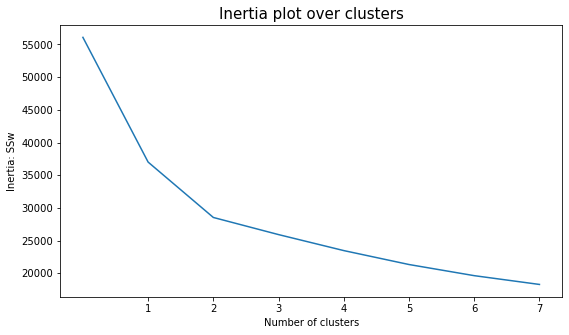

In [29]:
inertia_plot(8, df_bb)

In [30]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=1
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [31]:
# Obtaining the R² scores for each cluster solution on buying behavior variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_bb, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_bb, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.340168,0.128695,0.138562,0.000908,0.290677
3,0.491196,0.219197,0.141284,0.001682,0.411643
4,0.537917,0.265228,0.151999,0.002078,0.469348
5,0.581508,0.327595,0.252323,0.004114,0.521705
6,0.619513,0.339017,0.301194,0.005034,0.550681
7,0.649878,0.347249,0.301630,0.005591,0.578090
8,0.673843,0.490558,0.312701,0.006551,0.604303
9,0.691639,0.572180,0.313105,0.007001,0.626932


In [32]:
# cluster solution
number_clusters = 3
kmclust_bb = KMeans(n_clusters=number_clusters, init='k-means++', n_init=20, random_state=1)
km_labels_bb = kmclust_bb.fit_predict(df_bb)

#classyfing each cluster considering the data
real_labels_bb = km_labels_bb
mapping_bb = {0:'DrywhWine', 1:'Dryred', 2:'SweetWineLovers'}
real_labels_bb = [mapping_bb[i] for i in real_labels_bb]

#centroids
kmeans_bb = pd.concat((df_bb, pd.Series(real_labels_bb, name='labels')), axis=1)
kmeans_bb.groupby('labels').mean() 

,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
labels,,,,,,
Dryred,0.984063,-0.578914,-0.778372,-0.566925,-0.573442,-0.275620
DrywhWine,-0.435462,-0.003760,0.804348,-0.008542,0.017111,-0.184302
SweetWineLovers,-1.306031,1.405585,-0.071756,1.385473,1.306798,1.086953


In [33]:
kmeans_bb['labels'].value_counts()

DrywhWine          4058
Dryred             4037
SweetWineLovers    1576
Name: labels, dtype: int64

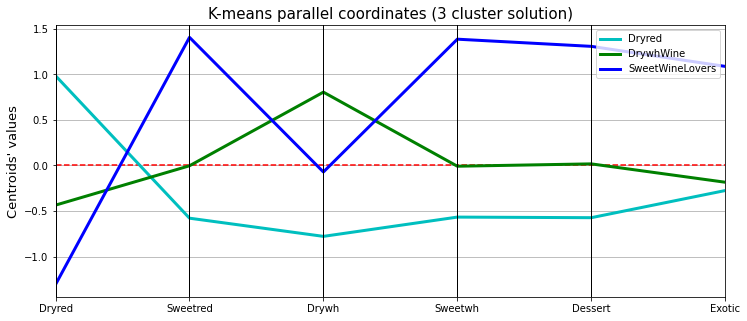

In [34]:
# parallel coordinates plot
finalkmeans_bb = kmeans_bb.groupby('labels').mean() 
finalkmeans_bb.reset_index(inplace=True)
plt.figure(figsize=(12,5))
parallel_coordinates(finalkmeans_bb, class_column='labels', cols=finalkmeans_bb.columns[1:], color=['c','g','b'], linewidth=3)  
plt.hlines(0, 0, 1000, colors="r", linestyles="dashed") # average value  
plt.ylabel("Centroids' values", fontsize=13)  
plt.title("K-means parallel coordinates (3 cluster solution)", fontsize=15) 
#plt.savefig('kmeans_bbehavior.png', bbox_inches='tight') # save fig
plt.show()

### Algorithm 2: K-Prototypes

In [35]:
kproto_bb = df.copy()

In [36]:
kproto_bb

,Dayswus,Edu,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,x0_18-37,x0_38-57,x0_58-78,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless
0,-1.213690,1.734653,0.288807,-0.832938,0.798753,0.696886,-0.384691,-0.200649,-0.637531,-0.767261,-0.903412,-0.327499,0,1,0,0,0,0
1,0.703488,0.662246,1.260762,-0.497816,1.121804,-0.076832,-0.910301,1.389446,-0.766684,-0.502652,-0.962881,-1.191971,0,0,1,0,0,0
2,-1.149455,-2.554974,-1.555072,0.016036,-0.754640,-2.011127,2.900373,-1.154705,3.237040,1.878831,1.891635,0.969210,1,0,0,1,1,1
3,0.743018,-0.410160,-0.321997,-0.207378,-0.751204,1.513589,-0.778899,-1.393219,-0.766684,-0.767261,2.307918,0.915180,0,1,0,1,1,1
4,-0.304513,-0.410160,-0.174418,-1.168059,-0.716836,1.470605,-0.910301,-1.313715,-0.637531,-0.767261,0.702253,1.131298,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,-0.615807,0.662246,-1.012050,-0.497816,-0.789007,0.954792,-0.778899,-0.280153,-0.766684,-0.899566,-0.546597,1.347416,0,1,0,1,1,1
9667,1.153136,1.734653,0.382300,0.083060,-0.087918,1.169714,-0.910301,-0.677677,-0.766684,-0.767261,-0.308721,-0.813764,0,1,0,0,0,0
9668,-1.495338,-0.946364,0.516731,-0.229719,0.613171,-0.893534,0.666529,0.594399,0.395688,0.688089,-0.189783,-1.300030,0,0,1,0,0,0
9669,-1.381691,-2.554974,-1.099224,0.217109,-0.713400,-1.925159,2.243360,-1.472724,4.011954,2.011135,1.475351,0.861151,1,0,0,0,0,1


In [37]:
kproto_bb.drop (customervalue_features, axis = 1, inplace = True) #second perspective

#selecting the variables we want to exclude to proceed with this perspective (numeric - Edu and Dayswus) and 
#selecting the categorical variables we want to include in order to extract more information related to clusters' profiles
#but also with the aim of this perspective

kproto_bb.drop ('Edu', axis = 1, inplace = True)
kproto_bb.drop ('Dayswus', axis = 1, inplace = True)
kproto_bb.drop ('x1_morethan5visits', axis = 1, inplace = True)
kproto_bb.drop ('x3_AverageAmountorless', axis = 1, inplace = True)
kproto_bb.drop ('x2_above32disc', axis = 1, inplace = True)

In [38]:
kproto_bb

,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,x0_18-37,x0_38-57,x0_58-78
0,0.696886,-0.384691,-0.200649,-0.637531,-0.767261,-0.903412,0,1,0
1,-0.076832,-0.910301,1.389446,-0.766684,-0.502652,-0.962881,0,0,1
2,-2.011127,2.900373,-1.154705,3.237040,1.878831,1.891635,1,0,0
3,1.513589,-0.778899,-1.393219,-0.766684,-0.767261,2.307918,0,1,0
4,1.470605,-0.910301,-1.313715,-0.637531,-0.767261,0.702253,0,1,0
...,...,...,...,...,...,...,...,...,...
9666,0.954792,-0.778899,-0.280153,-0.766684,-0.899566,-0.546597,0,1,0
9667,1.169714,-0.910301,-0.677677,-0.766684,-0.767261,-0.308721,0,1,0
9668,-0.893534,0.666529,0.594399,0.395688,0.688089,-0.189783,0,0,1
9669,-1.925159,2.243360,-1.472724,4.011954,2.011135,1.475351,1,0,0


In [39]:
# cluster solution
number_clusters = 3
kpclust = KPrototypes(n_clusters=number_clusters, init='Huang', n_jobs=-1, random_state = 1) 
kp_labels_bb = kpclust.fit_predict(kproto_bb, categorical=[6,7,8])

#classyfing each cluster considering the data
real_labels_bb2 = kp_labels_bb
mapping_bb = {0:'SweetWineLovers', 1:'DrywhWine', 2:'DryredWine'}
real_labels_bb2 = [mapping_bb[i] for i in real_labels_bb2]

kprototypes = pd.concat((kproto_bb, pd.Series(real_labels_bb2, name='labels')), axis=1) 
kprototypes.groupby('labels').mean() 

,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,x0_18-37,x0_38-57,x0_58-78
labels,,,,,,,,,
DryredWine,0.984325,-0.577352,-0.779305,-0.568846,-0.572089,-0.245334,0.138008,0.633142,0.228850
DrywhWine,-0.414541,-0.017337,0.787339,-0.016350,0.002945,-0.261524,0.297392,0.152457,0.550150
SweetWineLovers,-1.279086,1.339771,-0.005113,1.315475,1.249752,1.120808,0.748210,0.094272,0.157518


In [40]:
kprototypes['labels'].value_counts()

DryredWine         4007
DrywhWine          3988
SweetWineLovers    1676
Name: labels, dtype: int64

In [41]:
#defining a list with all numeric variables in this perspective
num_bb = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']

In [42]:
# adaptation for r2 calculation (
kprototypes2_bb = pd.concat((kproto_bb[num_bb], pd.Series(kp_labels_bb, name='labels')), axis=1) 
# r2 calculation
sst = get_ss(kprototypes2_bb[num_bb])  # get total sum of squares
ssw_labels = kprototypes2_bb.groupby('labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.48663982539204886

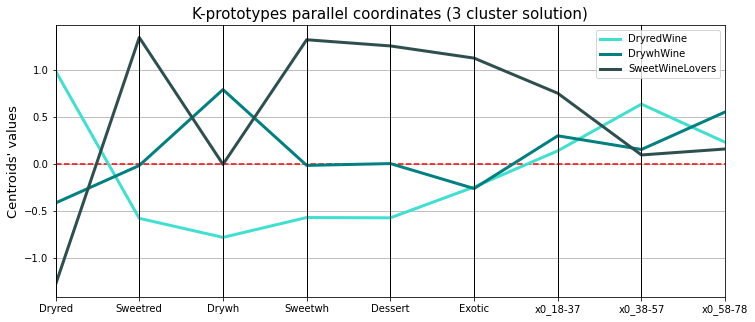

In [43]:
# parallel coordinates plot
kprototypes_bb = pd.concat([kprototypes[num_bb], kprototypes.iloc[:,6:]], axis=1).groupby('labels').mean()    
kprototypes_bb.reset_index(inplace=True)
plt.figure(figsize=(12,5))
parallel_coordinates(kprototypes_bb, class_column='labels', cols=kprototypes_bb.columns[1:], color=['turquoise' , 'teal', 'darkslategray'], linewidth=3)  
plt.hlines(0, 0, 1000, colors="r", linestyles="dashed") # average value  
plt.ylabel("Centroids' values", fontsize=13)  
plt.title("K-prototypes parallel coordinates (3 cluster solution)", fontsize=15)  
plt.savefig('kprototypes_buyingbehavior.png', bbox_inches='tight') # save fig
plt.show()

## Merging Perspectives from K-Means (using Hierarchical Clustering)

In [44]:
df_hc = df_copy.copy() #another copy of our dataset for modelling considering the different perspectives and using HC as a method for merging

In [45]:
# Applying the right clustering (algorithm and number of clusters) for each perspective

cv_labels = km_labels_cv

bb_labels = km_labels_bb

df_hc['cv_labels'] = cv_labels
df_hc['bb_labels'] = bb_labels

In [46]:
# Count label frequencies (contigency table)
df_hc.groupby(['cv_labels', 'bb_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('bb_labels', 'cv_labels', 0)

cv_labels,0,1,2
bb_labels,,,
0,939,1525,1594
1,1877,557,1603
2,248,195,1133


### Hierarchical Clustering

In [47]:
#updating num list
num = num.tolist()
num.remove('Dayswus')
num.remove('Edu')

In [48]:
# Centroids of the concatenated cluster labels
df_centroids = df_hc.groupby(['bb_labels', 'cv_labels'])\
    [num].mean()
df_centroids

Income   Recency       LTV    Dryred  Sweetred  \
bb_labels cv_labels                                                     
0         0          0.406062 -0.176067 -0.109322 -0.285253  0.051638   
          1          1.254711 -0.102937  1.526707 -0.514173  0.011929   
          2         -0.926606  0.149132 -0.721750 -0.448644 -0.051404   
1         0          0.353247 -0.194523 -0.093735  1.030410 -0.554457   
          1          1.205293 -0.026160  1.593225  0.757543 -0.525530   
          2         -0.530661  0.149987 -0.696411  1.008503 -0.626101   
2         0          0.273027 -0.202513 -0.199099 -0.862163  1.293341   
          1          1.248215 -0.099452  1.330897 -1.201258  1.351170   
          2         -1.331200 -0.049766 -0.724687 -1.421221  1.439520   

                        Drywh   Sweetwh   Dessert    Exotic  WebPurchase  
bb_labels cv_labels                                                       
0         0          0.400590  0.065448  0.098848 -0.277688    -0.414383  
          1          0.939579  0.002980  0.004530 -0.554396    -1.403873  
          2          0.912817 -0.063152 -0.019001  0.224785     0.868845  
1         0         -0.900688 -0.548632 -0.556152 -0.346075    -0.023845  
          1         -0.477845 -0.494699 -0.498376 -0.638630    -1.019891  
          2         -0.739575 -0.613441 -0.619770 -0.066986     0.728655  
2         0         -0.416081  1.039887  0.983107  0.471331    -0.480655  
          1          0.042350  1.193783  1.046330  0.003568    -1.375394  
          2         -0.016026  1.494110  1.422479  1.408166     0.818900

In [49]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

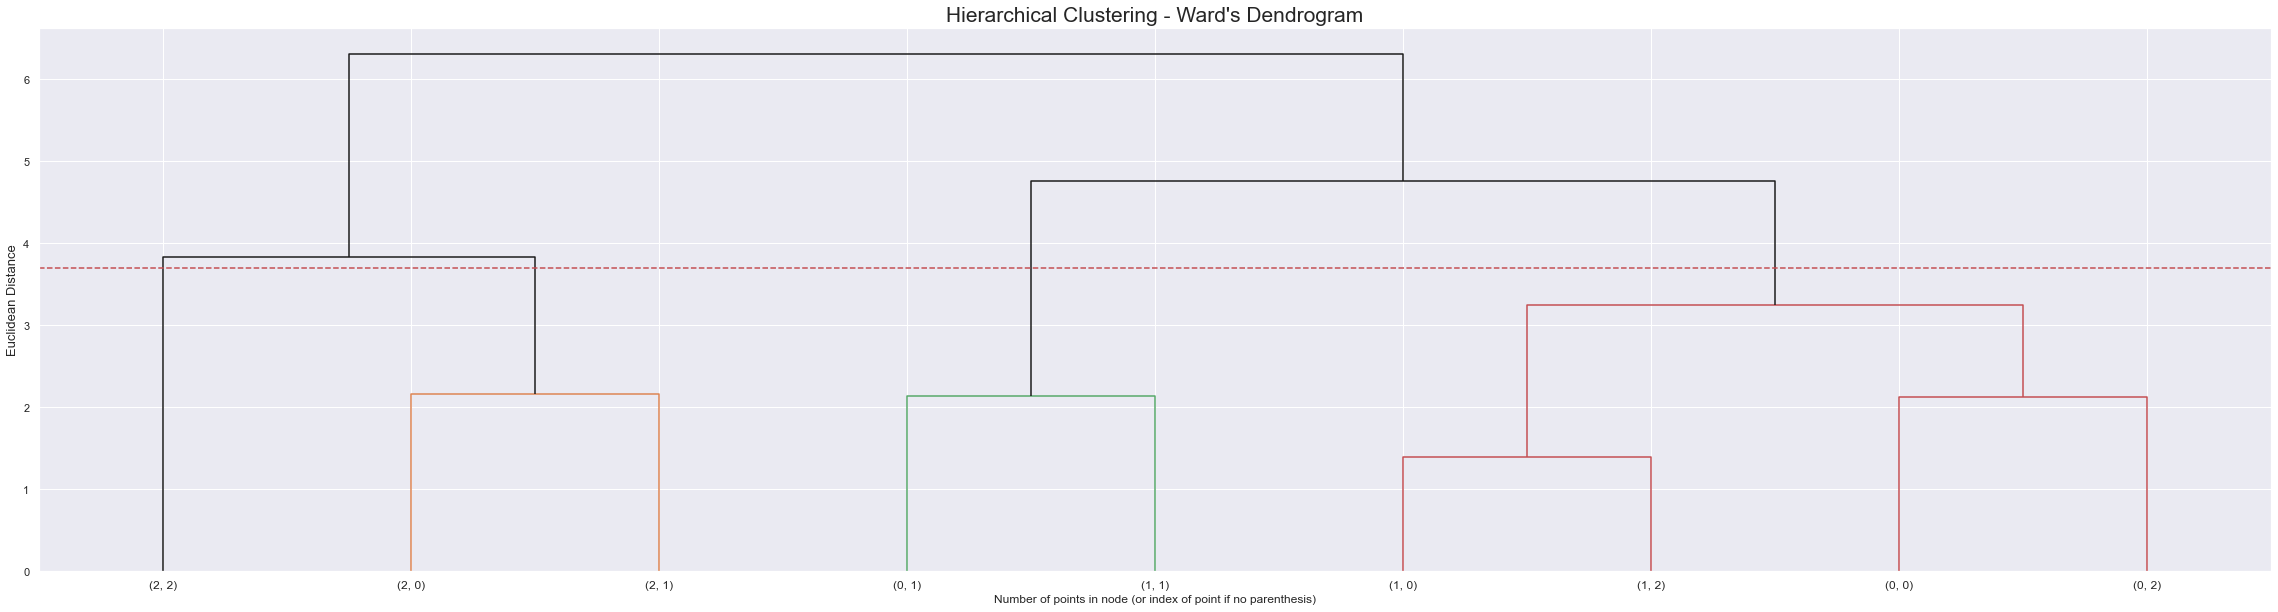

In [50]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(40,10))
# The Dendrogram parameters need to be tuned
y_threshold = 3.7
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [51]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)

df_centroids['hclust_labels'] = hclust_labels

df_centroids

Income   Recency       LTV    Dryred  Sweetred  \
bb_labels cv_labels                                                     
0         0          0.406062 -0.176067 -0.109322 -0.285253  0.051638   
          1          1.254711 -0.102937  1.526707 -0.514173  0.011929   
          2         -0.926606  0.149132 -0.721750 -0.448644 -0.051404   
1         0          0.353247 -0.194523 -0.093735  1.030410 -0.554457   
          1          1.205293 -0.026160  1.593225  0.757543 -0.525530   
          2         -0.530661  0.149987 -0.696411  1.008503 -0.626101   
2         0          0.273027 -0.202513 -0.199099 -0.862163  1.293341   
          1          1.248215 -0.099452  1.330897 -1.201258  1.351170   
          2         -1.331200 -0.049766 -0.724687 -1.421221  1.439520   

                        Drywh   Sweetwh   Dessert    Exotic  WebPurchase  \
bb_labels cv_labels                                                        
0         0          0.400590  0.065448  0.098848 -0.277688    -0.414383   
          1          0.939579  0.002980  0.004530 -0.554396    -1.403873   
          2          0.912817 -0.063152 -0.019001  0.224785     0.868845   
1         0         -0.900688 -0.548632 -0.556152 -0.346075    -0.023845   
          1         -0.477845 -0.494699 -0.498376 -0.638630    -1.019891   
          2         -0.739575 -0.613441 -0.619770 -0.066986     0.728655   
2         0         -0.416081  1.039887  0.983107  0.471331    -0.480655   
          1          0.042350  1.193783  1.046330  0.003568    -1.375394   
          2         -0.016026  1.494110  1.422479  1.408166     0.818900   

                     hclust_labels  
bb_labels cv_labels                 
0         0                      0  
          1                      2  
          2                      0  
1         0                      0  
          1                      2  
          2                      0  
2         0                      1  
          1                      1  
          2                      3

In [52]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df_hc.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['bb_labels'], row['cv_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[num]

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase
merged_labels,,,,,,,,,,
0,-0.213425,-0.008698,-0.423318,0.427028,-0.345552,-0.173781,-0.341316,-0.328431,-0.109663,0.352421
1,0.702286,-0.157148,0.474376,-1.011426,1.318796,-0.214288,1.107629,1.010937,0.265431,-0.874502
2,1.241490,-0.082397,1.544503,-0.173949,-0.131858,0.560374,-0.130165,-0.130013,-0.576932,-1.301146
3,-1.331200,-0.049766,-0.724687,-1.421221,1.439520,-0.016026,1.494110,1.422479,1.408166,0.818900


In [53]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['bb_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['cv_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('bb_labels', 'cv_labels', 0)

cv_labels,1,2
bb_labels,,
1,2082,6013
2,443,1133


In [54]:
#classyfing each cluster considering the data
df_merged = df_centroids 
#final_labels = hclust_labels
#mapping_merged = {0:'GoldenCustomersDrywh', 1:'MediumCustomersSweetWine', 2:'MediumCustomersDrywh', 3: 'GoldenCustomersSweetWine', 4: 'DryredCustomers'}
#final_labels = [mapping_merged[i] for i in final_labels]

#DryredCustomers
#HighIncomeSweetWine
#MediumCustomersDrywh
#GoldenCustomersDrywh
#BadCustomersSweetWine
df_merged['hclust_labels'] = hclust_labels

df_merged.groupby('hclust_labels').mean()  # centroid's cluster labels

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase
hclust_labels,,,,,,,,,,
0,-0.174490,-0.017868,-0.405305,0.326254,-0.295081,-0.081714,-0.289944,-0.274019,-0.116491,0.289818
1,0.760621,-0.150983,0.565899,-1.031711,1.322255,-0.186865,1.116835,1.014718,0.237450,-0.928025
2,1.230002,-0.064549,1.559966,0.121685,-0.256801,0.230867,-0.245859,-0.246923,-0.596513,-1.211882
3,-1.331200,-0.049766,-0.724687,-1.421221,1.439520,-0.016026,1.494110,1.422479,1.408166,0.818900


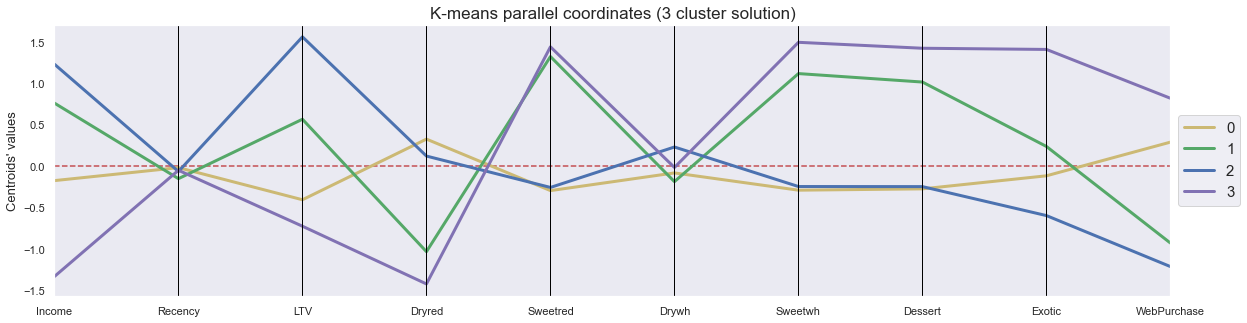

In [55]:
# parallel coordinates plot
#df_ = df_.drop(cat, axis=1)
finalmerged = df_merged.groupby('hclust_labels').mean() 
finalmerged.reset_index(inplace=True)
plt.figure(figsize=(20,5))
parallel_coordinates(finalmerged, class_column='hclust_labels', cols=finalmerged.columns[1:], color=['y','g','b', 'm','c', 'r', 'w'], linewidth=3)  
plt.hlines(0, 0, 1000, colors="r", linestyles="dashed") # average value  
plt.ylabel("Centroids' values", fontsize=13)  
plt.title("K-means parallel coordinates (3 cluster solution)", fontsize=17) 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
#plt.savefig('pc_kmeans_4clust.png', bbox_inches='tight') # save fig
plt.show()

In [56]:
num

['Income',
 'Recency',
 'LTV',
 'Dryred',
 'Sweetred',
 'Drywh',
 'Sweetwh',
 'Dessert',
 'Exotic',
 'WebPurchase']

In [57]:
# This is step can be quite time consuming
two_dim2 = TSNE(random_state=1).fit_transform(df_[num])

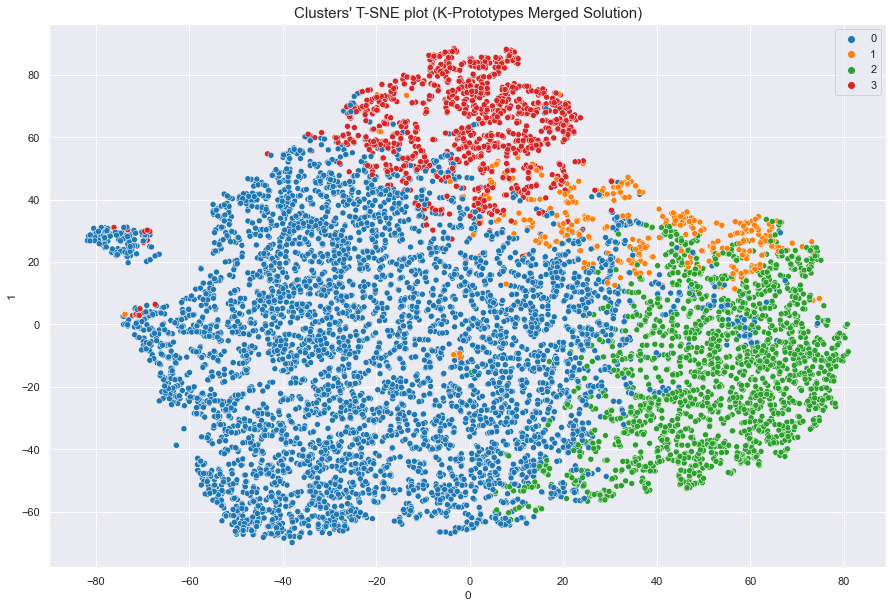

In [58]:
plt.figure(figsize=(15,10))
figure = sns.scatterplot(data=pd.DataFrame(two_dim2), x=0, y=1, hue=df_['merged_labels'].tolist(), palette=sns.color_palette("tab10",4))  
plt.title("Clusters' T-SNE plot (K-Prototypes Merged Solution)", fontsize=15) 
#plt.savefig('kmeans_tsne.png', bbox_inches='tight') # save fig
plt.show()

## Merging Perspectives from K-Prototypes (using Hierarchical Clustering)

In [59]:
df_hc2 = df_copy.copy() #another copy of our dataset for modelling considering the different perspectives and using HC as a method for merging

In [60]:
# Applying the right clustering (algorithm and number of clusters) for each perspective

cv_labels = kp_labels

bb_labels = kp_labels_bb

df_hc2['cv_labels'] = cv_labels
df_hc2['bb_labels'] = bb_labels

In [61]:
# Count label frequencies (contigency table)
df_hc.groupby(['cv_labels', 'bb_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('bb_labels', 'cv_labels', 0)

cv_labels,0,1,2
bb_labels,,,
0,939,1525,1594
1,1877,557,1603
2,248,195,1133


### Hierarchical Clustering Part

In [62]:
df_hc2.drop('Dayswus', axis = 1,  inplace = True)
df_hc2.drop('Edu', axis = 1,  inplace = True)

In [63]:
variables = df_hc2.columns.tolist()
variables.remove('cv_labels')
variables.remove('bb_labels')

In [64]:
# Centroids of the concatenated cluster labels
df_centroids = df_hc2.groupby(['bb_labels', 'cv_labels'])\
    [variables].mean()
df_centroids

Income   Recency       LTV    Dryred  Sweetred  \
bb_labels cv_labels                                                     
0         0         -1.301402 -0.036292 -0.725779 -1.360842  1.337742   
          1          0.266896 -0.196540 -0.180388 -0.862256  1.291111   
          2          1.261993 -0.112563  1.344079 -1.239768  1.425299   
1         0         -0.898485  0.133731 -0.724750 -0.431869 -0.094131   
          1          0.485784 -0.165482 -0.026347 -0.286063  0.082406   
          2          1.258798 -0.102552  1.543840 -0.471233 -0.005236   
2         0         -0.495864  0.102462 -0.710315  0.983986 -0.614094   
          1          0.368150 -0.164401 -0.042089  1.018098 -0.548041   
          2          1.200058 -0.008539  1.604201  0.848992 -0.546854   

                        Drywh   Sweetwh   Dessert    Exotic  WebPurchase  \
bb_labels cv_labels                                                        
0         0          0.064014  1.377226  1.324747  1.374668     0.809744   
          1         -0.409729  1.050793  0.961144  0.461593    -0.501773   
          2          0.036411  1.213915  1.079356  0.088707    -1.383380   
1         0          0.951124 -0.092390 -0.059926  0.128278     0.856212   
          1          0.370237  0.075209  0.109510 -0.345287    -0.476878   
          2          0.876128 -0.000327 -0.001112 -0.559877    -1.407161   
2         0         -0.716227 -0.601447 -0.606436 -0.054496     0.690864   
          1         -0.890791 -0.544710 -0.544921 -0.337270    -0.027288   
          2         -0.584078 -0.534209 -0.542644 -0.647830    -0.979168   

                     x0_18-37  x0_38-57  x0_58-78  x1_morethan5visits  \
bb_labels cv_labels                                                     
0         0          0.960063  0.039937  0.000000            0.774471   
          1          0.119149  0.446809  0.434043            0.165957   
          2          0.000000  0.012195  0.987805            0.036585   
1         0          0.801939  0.193213  0.004848            0.831025   
          1          0.030635  0.338074  0.631291            0.203501   
          2          0.000000  0.012270  0.987730            0.030061   
2         0          0.292833  0.706607  0.000560            0.796193   
          1          0.016844  0.694554  0.288602            0.458731   
          2          0.000000  0.086364  0.913636            0.202273   

                     x2_above32disc  x3_AverageAmountorless  
bb_labels cv_labels                                          
0         0                0.829287                0.978074  
          1                0.136170                0.336170  
          2                0.000000                0.000000  
1         0                0.856648                0.940443  
          1                0.098468                0.180525  
          2                0.000000                0.000000  
2         0                0.814110                0.849384  
          1                0.121842                0.193150  
          2                0.000000                0.000000

In [65]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

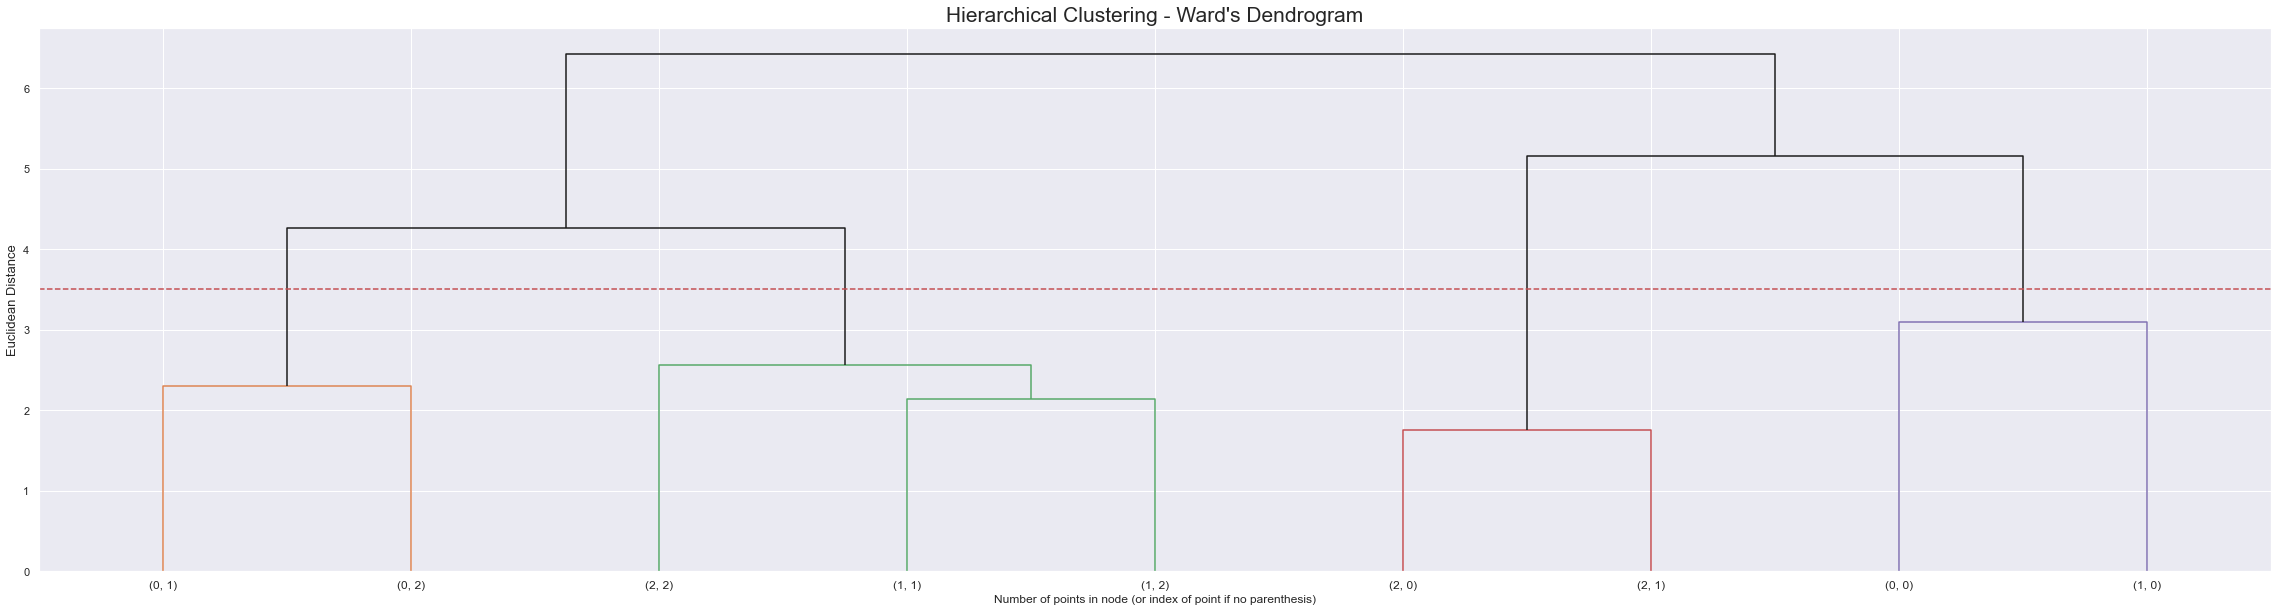

In [66]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(40,10))
# The Dendrogram parameters need to be tuned
y_threshold = 3.5
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [67]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4,

)   
    
hclust_labels = hclust.fit_predict(df_centroids)

df_centroids['hclust_labels'] = hclust_labels

df_centroids

Income   Recency       LTV    Dryred  Sweetred  \
bb_labels cv_labels                                                     
0         0         -1.301402 -0.036292 -0.725779 -1.360842  1.337742   
          1          0.266896 -0.196540 -0.180388 -0.862256  1.291111   
          2          1.261993 -0.112563  1.344079 -1.239768  1.425299   
1         0         -0.898485  0.133731 -0.724750 -0.431869 -0.094131   
          1          0.485784 -0.165482 -0.026347 -0.286063  0.082406   
          2          1.258798 -0.102552  1.543840 -0.471233 -0.005236   
2         0         -0.495864  0.102462 -0.710315  0.983986 -0.614094   
          1          0.368150 -0.164401 -0.042089  1.018098 -0.548041   
          2          1.200058 -0.008539  1.604201  0.848992 -0.546854   

                        Drywh   Sweetwh   Dessert    Exotic  WebPurchase  \
bb_labels cv_labels                                                        
0         0          0.064014  1.377226  1.324747  1.374668     0.809744   
          1         -0.409729  1.050793  0.961144  0.461593    -0.501773   
          2          0.036411  1.213915  1.079356  0.088707    -1.383380   
1         0          0.951124 -0.092390 -0.059926  0.128278     0.856212   
          1          0.370237  0.075209  0.109510 -0.345287    -0.476878   
          2          0.876128 -0.000327 -0.001112 -0.559877    -1.407161   
2         0         -0.716227 -0.601447 -0.606436 -0.054496     0.690864   
          1         -0.890791 -0.544710 -0.544921 -0.337270    -0.027288   
          2         -0.584078 -0.534209 -0.542644 -0.647830    -0.979168   

                     x0_18-37  x0_38-57  x0_58-78  x1_morethan5visits  \
bb_labels cv_labels                                                     
0         0          0.960063  0.039937  0.000000            0.774471   
          1          0.119149  0.446809  0.434043            0.165957   
          2          0.000000  0.012195  0.987805            0.036585   
1         0          0.801939  0.193213  0.004848            0.831025   
          1          0.030635  0.338074  0.631291            0.203501   
          2          0.000000  0.012270  0.987730            0.030061   
2         0          0.292833  0.706607  0.000560            0.796193   
          1          0.016844  0.694554  0.288602            0.458731   
          2          0.000000  0.086364  0.913636            0.202273   

                     x2_above32disc  x3_AverageAmountorless  hclust_labels  
bb_labels cv_labels                                                         
0         0                0.829287                0.978074              0  
          1                0.136170                0.336170              3  
          2                0.000000                0.000000              3  
1         0                0.856648                0.940443              0  
          1                0.098468                0.180525              1  
          2                0.000000                0.000000              1  
2         0                0.814110                0.849384              2  
          1                0.121842                0.193150              2  
          2                0.000000                0.000000              1

In [68]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_2 = df_hc2.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_2['merged_labels'] = df_2.apply(
    lambda row: cluster_mapper[
        (row['bb_labels'], row['cv_labels'])
    ], axis=1
)

# Merged cluster centroids
df_2.groupby('merged_labels').mean()[variables]

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,x0_18-37,x0_38-57,x0_58-78,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless
merged_labels,,,,,,,,,,,,,,,,
0,-1.087579,0.053937,-0.725233,-0.867848,0.577865,0.534792,0.597319,0.589919,0.713225,0.834404,0.876148,0.121279,0.002573,0.804484,0.843807,0.958104
1,1.013362,-0.107965,1.071792,-0.219844,-0.058254,0.505862,-0.055913,-0.047079,-0.507117,-1.059106,0.009383,0.122989,0.867627,0.108579,0.030161,0.055295
2,-0.064462,-0.030782,-0.376671,1.001018,-0.581114,-0.803387,-0.573118,-0.575722,-0.195685,0.332292,0.155032,0.700589,0.144379,0.627698,0.468461,0.521727
3,0.675908,-0.162023,0.446210,-1.017424,1.346266,-0.226353,1.117840,1.009732,0.308327,-0.864138,0.070175,0.268170,0.661654,0.112782,0.080201,0.197995


In [69]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_2.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['bb_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['cv_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('bb_labels', 'cv_labels', 0)

cv_labels,0,1,2
bb_labels,,,
0,NaN,NaN,399.0
1,2721.0,NaN,NaN
2,NaN,3567.0,2984.0


In [70]:
#classyfing each cluster considering the data
df_merged = df_centroids
final_labels = hclust_labels
mapping_merged = {0:'SweetWineBronzeCustomers', 1:'DrywhGoldCustomers', 2:'DryredSilverCustomers', 3: 'SweetWineGoldCustomers'}
final_labels = [mapping_merged[i] for i in final_labels]


df_merged['hclust_labels'] = final_labels 

df_merged.groupby('hclust_labels').mean()  # centroid's cluster labels

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,x0_18-37,x0_38-57,x0_58-78,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless
hclust_labels,,,,,,,,,,,,,,,,
DryredSilverCustomers,-0.063857,-0.030969,-0.376202,1.001042,-0.581067,-0.803509,-0.573078,-0.575679,-0.195883,0.331788,0.154839,0.700580,0.144581,0.627462,0.467976,0.521267
DrywhGoldCustomers,0.981547,-0.092191,1.040565,0.030565,-0.156561,0.220762,-0.153109,-0.144749,-0.517665,-0.954402,0.010212,0.145569,0.844219,0.145278,0.032823,0.060175
SweetWineBronzeCustomers,-1.099943,0.048719,-0.725265,-0.896356,0.621805,0.507569,0.642418,0.632410,0.751473,0.832978,0.881001,0.116575,0.002424,0.802748,0.842968,0.959258
SweetWineGoldCustomers,0.764444,-0.154552,0.581846,-1.051012,1.358205,-0.186659,1.132354,1.020250,0.275150,-0.942576,0.059574,0.229502,0.710924,0.101271,0.068085,0.168085


In [71]:
df_merged

Income   Recency       LTV    Dryred  Sweetred  \
bb_labels cv_labels                                                     
0         0         -1.301402 -0.036292 -0.725779 -1.360842  1.337742   
          1          0.266896 -0.196540 -0.180388 -0.862256  1.291111   
          2          1.261993 -0.112563  1.344079 -1.239768  1.425299   
1         0         -0.898485  0.133731 -0.724750 -0.431869 -0.094131   
          1          0.485784 -0.165482 -0.026347 -0.286063  0.082406   
          2          1.258798 -0.102552  1.543840 -0.471233 -0.005236   
2         0         -0.495864  0.102462 -0.710315  0.983986 -0.614094   
          1          0.368150 -0.164401 -0.042089  1.018098 -0.548041   
          2          1.200058 -0.008539  1.604201  0.848992 -0.546854   

                        Drywh   Sweetwh   Dessert    Exotic  WebPurchase  \
bb_labels cv_labels                                                        
0         0          0.064014  1.377226  1.324747  1.374668     0.809744   
          1         -0.409729  1.050793  0.961144  0.461593    -0.501773   
          2          0.036411  1.213915  1.079356  0.088707    -1.383380   
1         0          0.951124 -0.092390 -0.059926  0.128278     0.856212   
          1          0.370237  0.075209  0.109510 -0.345287    -0.476878   
          2          0.876128 -0.000327 -0.001112 -0.559877    -1.407161   
2         0         -0.716227 -0.601447 -0.606436 -0.054496     0.690864   
          1         -0.890791 -0.544710 -0.544921 -0.337270    -0.027288   
          2         -0.584078 -0.534209 -0.542644 -0.647830    -0.979168   

                     x0_18-37  x0_38-57  x0_58-78  x1_morethan5visits  \
bb_labels cv_labels                                                     
0         0          0.960063  0.039937  0.000000            0.774471   
          1          0.119149  0.446809  0.434043            0.165957   
          2          0.000000  0.012195  0.987805            0.036585   
1         0          0.801939  0.193213  0.004848            0.831025   
          1          0.030635  0.338074  0.631291            0.203501   
          2          0.000000  0.012270  0.987730            0.030061   
2         0          0.292833  0.706607  0.000560            0.796193   
          1          0.016844  0.694554  0.288602            0.458731   
          2          0.000000  0.086364  0.913636            0.202273   

                     x2_above32disc  x3_AverageAmountorless  \
bb_labels cv_labels                                           
0         0                0.829287                0.978074   
          1                0.136170                0.336170   
          2                0.000000                0.000000   
1         0                0.856648                0.940443   
          1                0.098468                0.180525   
          2                0.000000                0.000000   
2         0                0.814110                0.849384   
          1                0.121842                0.193150   
          2                0.000000                0.000000   

                                hclust_labels  
bb_labels cv_labels                            
0         0          SweetWineBronzeCustomers  
          1            SweetWineGoldCustomers  
          2            SweetWineGoldCustomers  
1         0          SweetWineBronzeCustomers  
          1                DrywhGoldCustomers  
          2                DrywhGoldCustomers  
2         0             DryredSilverCustomers  
          1             DryredSilverCustomers  
          2                DrywhGoldCustomers

In [72]:
df_2['merged_labels'].value_counts()

2    3567
1    2984
0    2721
3     399
Name: merged_labels, dtype: int64

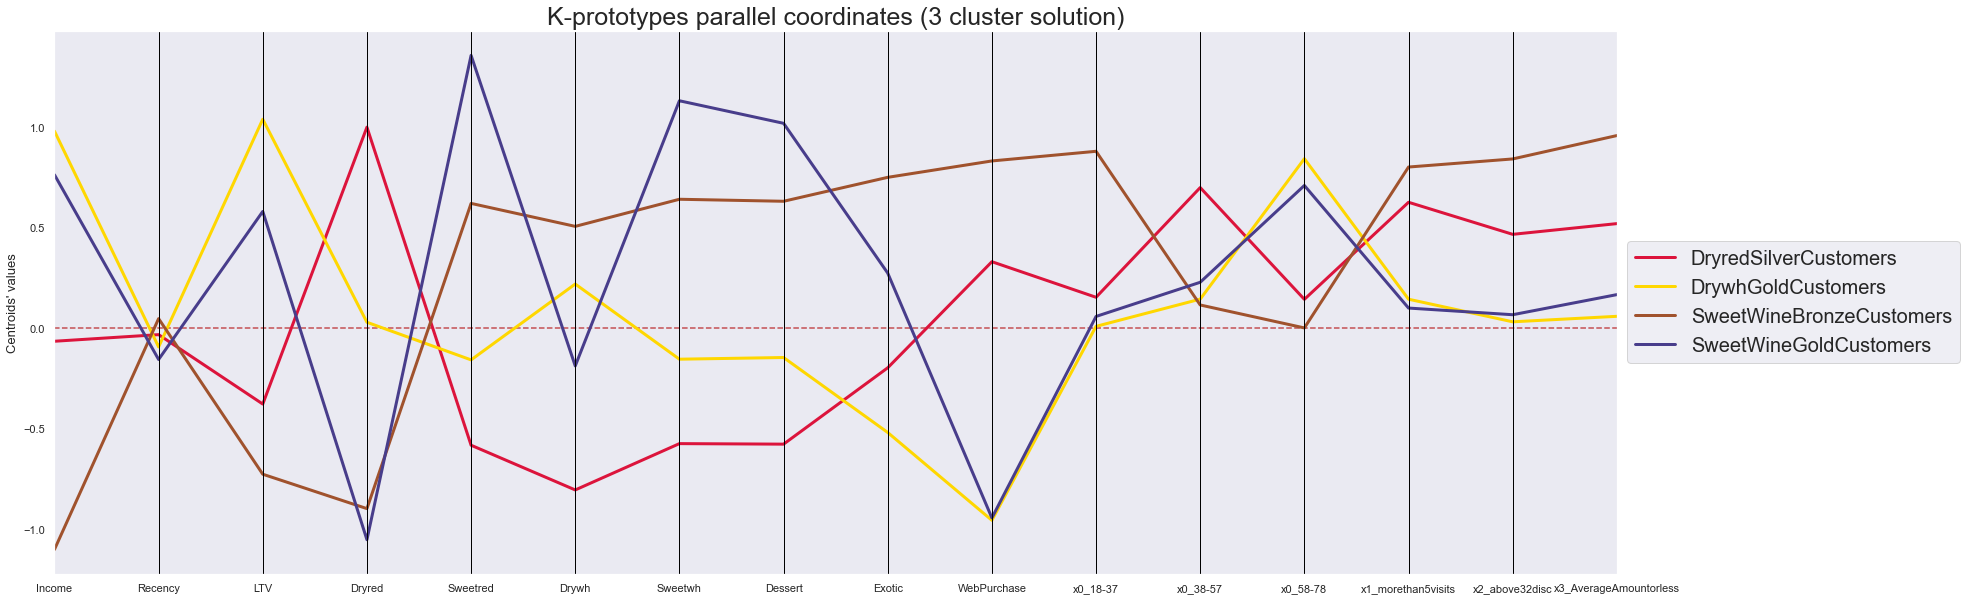

In [73]:
# parallel coordinates plot
finalmerged = df_merged.groupby('hclust_labels').mean() 
finalmerged.reset_index(inplace=True)
plt.figure(figsize=(28,10))
parallel_coordinates(finalmerged, class_column='hclust_labels', cols=finalmerged.columns[1:], color=['crimson','gold','sienna', 'darkslateblue'], linewidth=3)  
plt.hlines(0, 0, 1000, colors="r", linestyles="dashed") # average value  
plt.ylabel("Centroids' values", fontsize=13)  
plt.title("K-prototypes parallel coordinates (3 cluster solution)", fontsize=25) 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
plt.savefig('kprototypes_finalmergedclusters.png', bbox_inches='tight') # save fig
plt.show()

In [84]:
countplot_labels = finalmerged['hclust_labels'].tolist()

In [85]:
df_countplot = df_2.copy()
df_countplot['Names'] = df_countplot['merged_labels']

In [86]:
#classyfing each cluster considering the data
df_countplot['Names'] = df_countplot['merged_labels']
mapping_merged = {0:'SweetWineBronzeCustomers', 1:'DrywhGoldCustomers', 2:'DryredSilverCustomers', 3: 'SweetWineGoldCustomers'}
df_countplot['Names'] = [mapping_merged[i] for i in df_countplot['Names']]

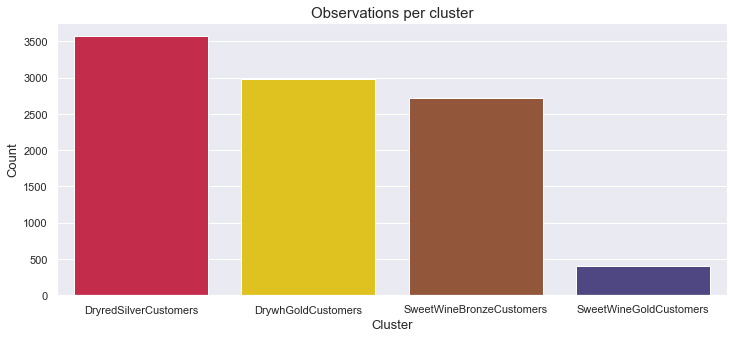

In [87]:
# observations per cluster
plt.figure(figsize=(12,5))
figure = sns.countplot(x="Names", data=df_countplot, palette=['crimson','gold','sienna', 'darkslateblue'])  
plt.xlabel('Cluster', fontsize=13)  
plt.ylabel('Count', fontsize=13) 
plt.title('Observations per cluster', fontsize=15)  
plt.savefig('count_plot_kprototypes_finalmergedsolutions.png', bbox_inches='tight') # save fig
plt.show()

# Final Merged solution - Data Visualization

In [93]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling (Numeric variables)", fontsize=23)
    plt.show()

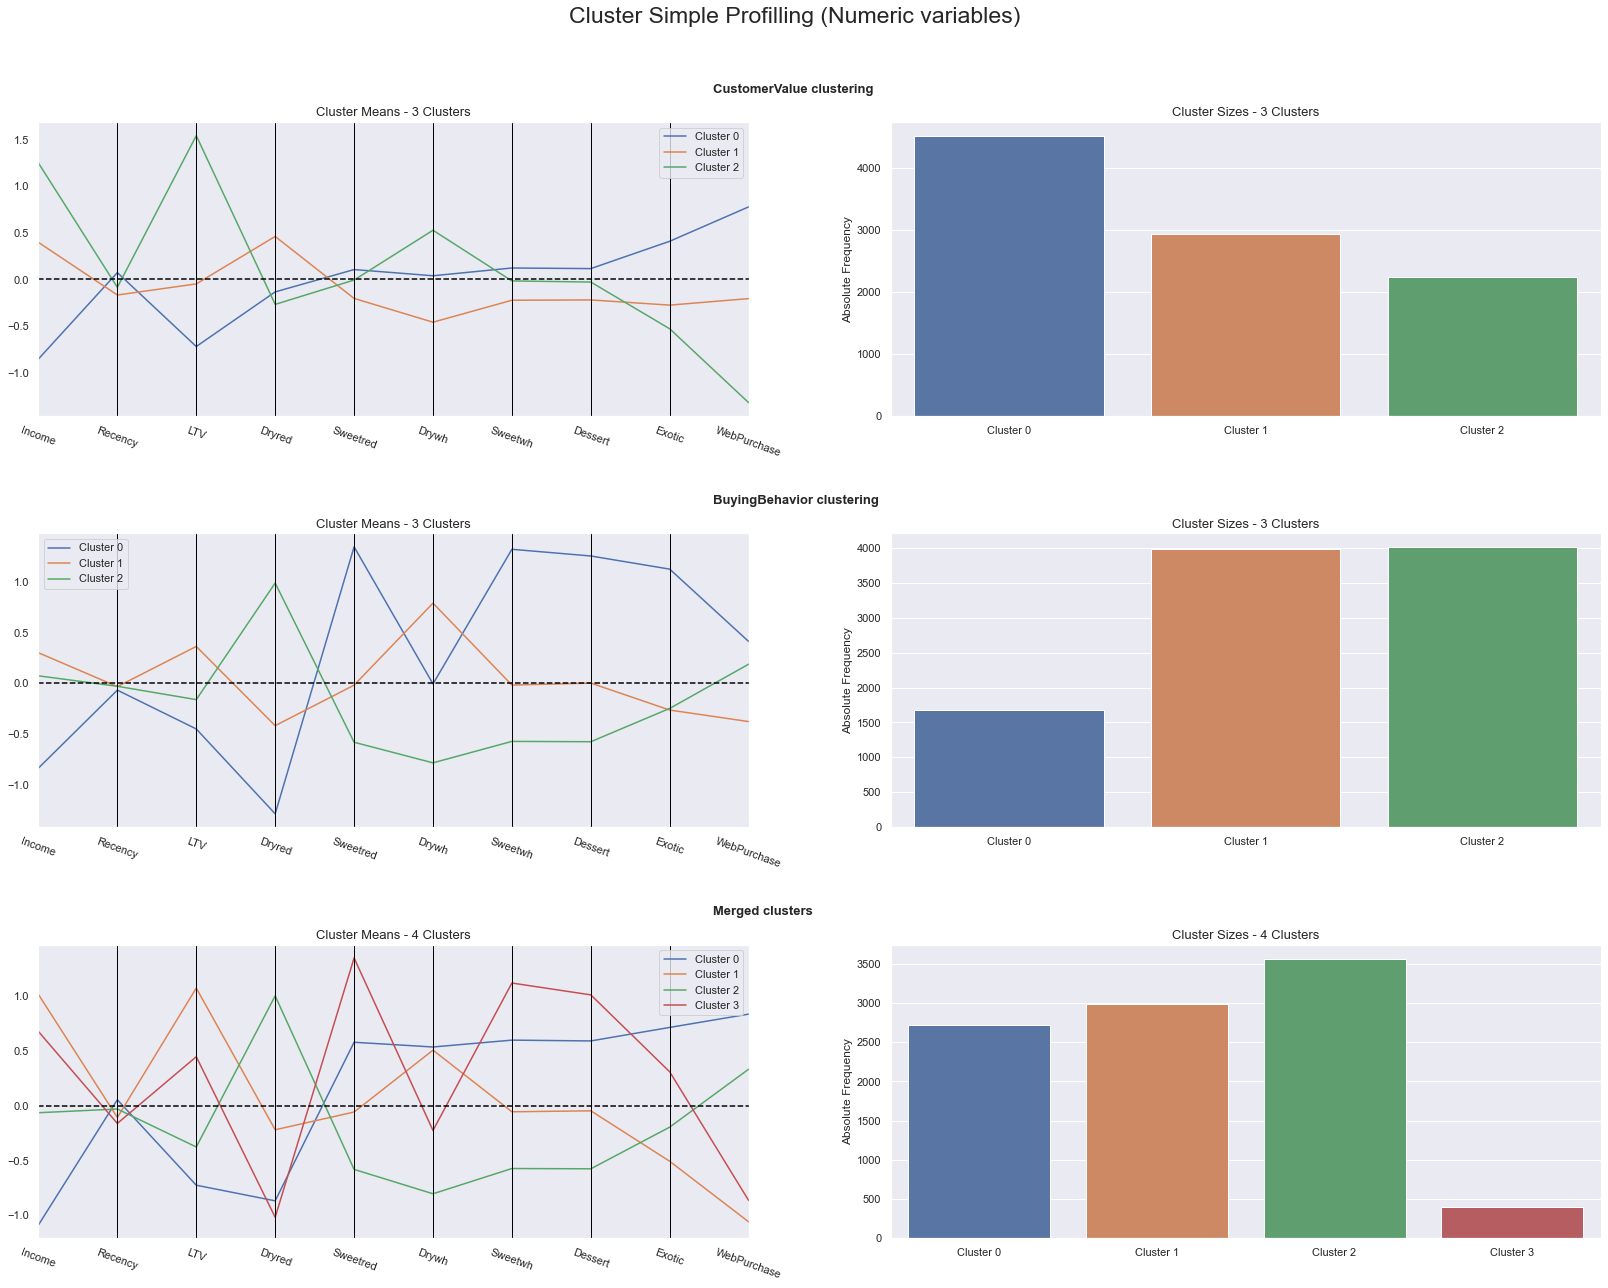

In [94]:
# Profilling each cluster (customer value, buying behavior, merged)
cluster_profiles(
    df = df_2.drop(cat, axis = 1), 
    label_columns = ['cv_labels', 'bb_labels', 'merged_labels'], 
    figsize = (28, 20), 
    compar_titles = ["CustomerValue clustering", "BuyingBehavior clustering", "Merged clusters"]
)

In [95]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=1).fit_transform(df_2[num])

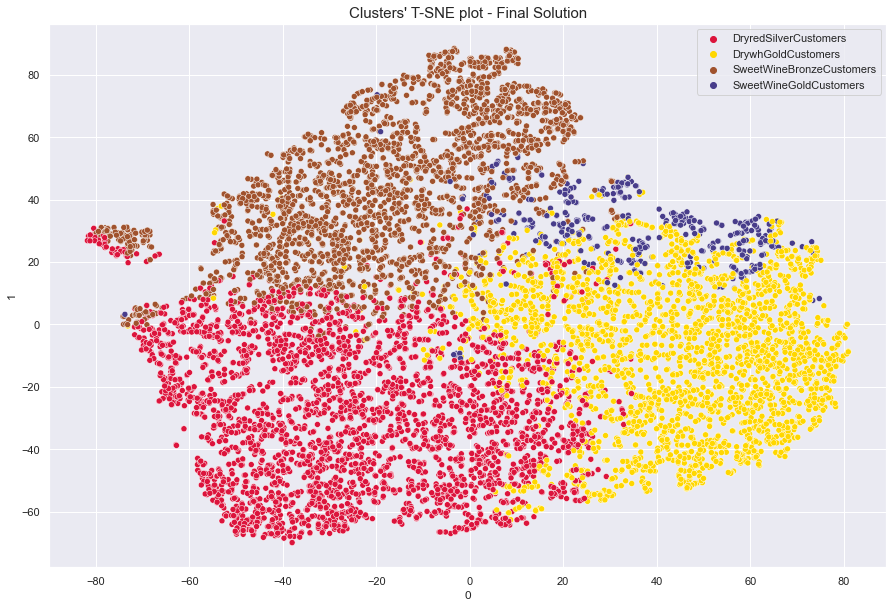

In [96]:
plt.figure(figsize=(15,10))
figure = sns.scatterplot(data=pd.DataFrame(two_dim), x=0, y=1, hue=df_countplot['Names'].tolist(), palette=['crimson','gold','sienna', 'darkslateblue'])  
plt.title("Clusters' T-SNE plot - Final Solution", fontsize=15) 
plt.savefig('tsne_finalmergedsolution.png', bbox_inches='tight') # save fig
plt.show()

# Outliers' Classification - DecisionTreeClassifier

In [97]:
df_out.drop(['Dayswus', 'Edu'], axis = 1, inplace = True)

In [98]:
df_out_cv = df_out.copy()
df_out_bb = df_out.copy()
df_out_merg = df_out.copy()

### cv_labels

In [99]:
# Preparing the data
X = df_2.drop(columns=['cv_labels','bb_labels','merged_labels'])
y = df_2.cv_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=1, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 91.68% of the customers correctly


In [100]:
df_out.reset_index(inplace = True)
df_out.drop('index', axis = 1, inplace = True)

In [101]:
# Predicting the cluster labels of the outliers
df_out['cv_labels'] = dt.predict(df_out_cv)

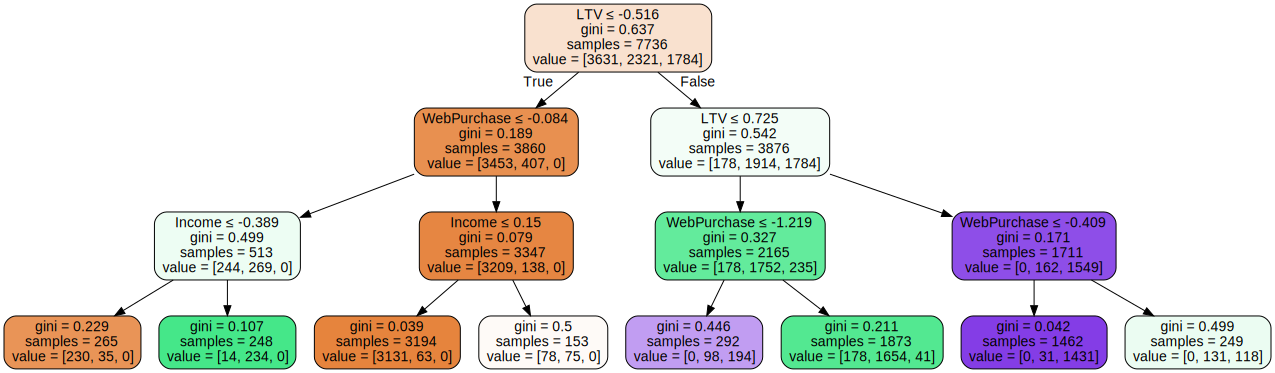

In [102]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)

### bb_labels

In [103]:
# Preparing the data
X = df_2.drop(columns=['cv_labels','bb_labels','merged_labels'])
y = df_2.bb_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=1, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 87.03% of the customers correctly


In [104]:
# Predicting the cluster labels of the outliers
df_out['bb_labels'] = dt.predict(df_out_bb)

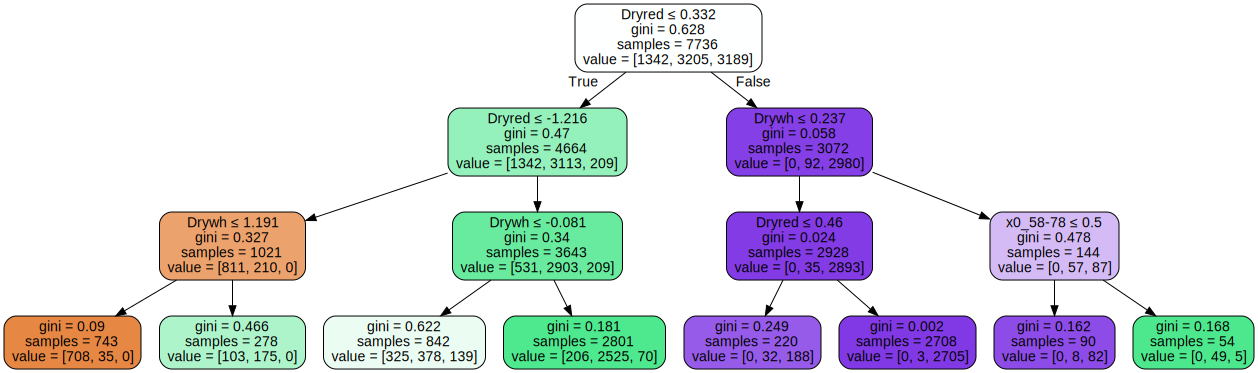

In [105]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)

### merged_labels

In [106]:
# Preparing the data
X = df_2.drop(columns=['cv_labels','bb_labels','merged_labels'])
y = df_2.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=1, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 89.25% of the customers correctly


In [107]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out_merg)

### Final concatenation

In [108]:
#dataset with DBSCAN outliers after classification
df_out

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,x0_18-37,x0_38-57,x0_58-78,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless,cv_labels,bb_labels,merged_labels
0,-1.540135,4.193882,-0.734020,-1.882174,5.659827,-1.631734,3.495345,-0.899566,1.891635,0.104737,1,0,0,0,1,1,0,0,0
1,-1.586187,4.216223,-0.737457,-1.710237,1.454945,-1.154705,2.332973,3.334181,0.821191,1.185328,1,0,0,0,1,1,0,0,0
2,-1.392921,6.964218,-0.730583,-1.710237,0.535127,1.786969,1.170602,0.555785,1.772696,1.239357,1,0,0,1,1,1,0,1,0
3,-0.510259,6.428024,-0.727147,-0.549660,-0.253289,-0.200649,0.783145,1.481917,0.702253,-0.381528,1,0,0,0,1,1,0,1,0
4,-0.165287,4.931149,-0.737457,-1.237409,1.849152,0.594399,0.395688,0.555785,0.821191,0.915180,0,1,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,-1.590789,0.217109,-0.720273,-2.011127,5.265619,-1.393219,0.008231,3.201877,3.259423,1.347416,1,0,0,1,0,1,0,0,0
101,-1.304761,0.105402,-0.709963,-1.968143,4.608606,-1.552229,-0.508379,4.524922,-0.546597,0.699062,1,0,0,1,0,1,0,0,0
102,-1.575815,3.143835,-0.754640,-0.334738,1.192140,0.037866,0.395688,-0.634956,0.107563,0.158767,1,0,0,1,1,1,0,1,0
103,-1.908809,-0.274402,-0.740893,-1.839190,2.111957,-0.916191,-0.379227,5.451055,4.091990,1.995770,1,0,0,1,1,1,0,0,0


In [109]:
#our final dataset before outliers' classification
df_2

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,x0_18-37,x0_38-57,x0_58-78,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless,cv_labels,bb_labels,merged_labels
0,0.288807,-0.832938,0.798753,0.696886,-0.384691,-0.200649,-0.637531,-0.767261,-0.903412,-0.327499,0,1,0,0,0,0,1,2,2
1,1.260762,-0.497816,1.121804,-0.076832,-0.910301,1.389446,-0.766684,-0.502652,-0.962881,-1.191971,0,0,1,0,0,0,2,1,1
2,-1.555072,0.016036,-0.754640,-2.011127,2.900373,-1.154705,3.237040,1.878831,1.891635,0.969210,1,0,0,1,1,1,0,0,0
3,-0.321997,-0.207378,-0.751204,1.513589,-0.778899,-1.393219,-0.766684,-0.767261,2.307918,0.915180,0,1,0,1,1,1,0,2,2
4,-0.174418,-1.168059,-0.716836,1.470605,-0.910301,-1.313715,-0.637531,-0.767261,0.702253,1.131298,0,1,0,1,1,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,-1.012050,-0.497816,-0.789007,0.954792,-0.778899,-0.280153,-0.766684,-0.899566,-0.546597,1.347416,0,1,0,1,1,1,0,2,2
9667,0.382300,0.083060,-0.087918,1.169714,-0.910301,-0.677677,-0.766684,-0.767261,-0.308721,-0.813764,0,1,0,0,0,0,1,2,2
9668,0.516731,-0.229719,0.613171,-0.893534,0.666529,0.594399,0.395688,0.688089,-0.189783,-1.300030,0,0,1,0,0,0,2,1,1
9669,-1.099224,0.217109,-0.713400,-1.925159,2.243360,-1.472724,4.011954,2.011135,1.475351,0.861151,1,0,0,0,0,1,0,0,0


In [110]:
#concatenating these two datasets
concatenation = [df_out, df_2]
concatenated_final_solution = pd.concat(concatenation, axis = 0)

In [111]:
concatenated_final_solution #final solution dataset

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,x0_18-37,x0_38-57,x0_58-78,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless,cv_labels,bb_labels,merged_labels
0,-1.540135,4.193882,-0.734020,-1.882174,5.659827,-1.631734,3.495345,-0.899566,1.891635,0.104737,1,0,0,0,1,1,0,0,0
1,-1.586187,4.216223,-0.737457,-1.710237,1.454945,-1.154705,2.332973,3.334181,0.821191,1.185328,1,0,0,0,1,1,0,0,0
2,-1.392921,6.964218,-0.730583,-1.710237,0.535127,1.786969,1.170602,0.555785,1.772696,1.239357,1,0,0,1,1,1,0,1,0
3,-0.510259,6.428024,-0.727147,-0.549660,-0.253289,-0.200649,0.783145,1.481917,0.702253,-0.381528,1,0,0,0,1,1,0,1,0
4,-0.165287,4.931149,-0.737457,-1.237409,1.849152,0.594399,0.395688,0.555785,0.821191,0.915180,0,1,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,-1.012050,-0.497816,-0.789007,0.954792,-0.778899,-0.280153,-0.766684,-0.899566,-0.546597,1.347416,0,1,0,1,1,1,0,2,2
9667,0.382300,0.083060,-0.087918,1.169714,-0.910301,-0.677677,-0.766684,-0.767261,-0.308721,-0.813764,0,1,0,0,0,0,1,2,2
9668,0.516731,-0.229719,0.613171,-0.893534,0.666529,0.594399,0.395688,0.688089,-0.189783,-1.300030,0,0,1,0,0,0,2,1,1
9669,-1.099224,0.217109,-0.713400,-1.925159,2.243360,-1.472724,4.011954,2.011135,1.475351,0.861151,1,0,0,0,0,1,0,0,0


# More Visualizations

In [113]:
visualization_df = concatenated_final_solution.copy()

In [114]:
#classyfing each cluster considering the data
visualization_df['Names'] = visualization_df['merged_labels']
mapping_merged = {0:'SweetWineBronzeCustomers', 1:'DrywhGoldCustomers', 2:'DryredSilverCustomers', 3: 'SweetWineGoldCustomers'}
visualization_df['Names'] = [mapping_merged[i] for i in visualization_df['Names']]

In [115]:
visualization_df

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,x0_18-37,x0_38-57,x0_58-78,x1_morethan5visits,x2_above32disc,x3_AverageAmountorless,cv_labels,bb_labels,merged_labels,Names
0,-1.540135,4.193882,-0.734020,-1.882174,5.659827,-1.631734,3.495345,-0.899566,1.891635,0.104737,1,0,0,0,1,1,0,0,0,SweetWineBronzeCustomers
1,-1.586187,4.216223,-0.737457,-1.710237,1.454945,-1.154705,2.332973,3.334181,0.821191,1.185328,1,0,0,0,1,1,0,0,0,SweetWineBronzeCustomers
2,-1.392921,6.964218,-0.730583,-1.710237,0.535127,1.786969,1.170602,0.555785,1.772696,1.239357,1,0,0,1,1,1,0,1,0,SweetWineBronzeCustomers
3,-0.510259,6.428024,-0.727147,-0.549660,-0.253289,-0.200649,0.783145,1.481917,0.702253,-0.381528,1,0,0,0,1,1,0,1,0,SweetWineBronzeCustomers
4,-0.165287,4.931149,-0.737457,-1.237409,1.849152,0.594399,0.395688,0.555785,0.821191,0.915180,0,1,0,1,1,1,0,0,0,SweetWineBronzeCustomers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9666,-1.012050,-0.497816,-0.789007,0.954792,-0.778899,-0.280153,-0.766684,-0.899566,-0.546597,1.347416,0,1,0,1,1,1,0,2,2,DryredSilverCustomers
9667,0.382300,0.083060,-0.087918,1.169714,-0.910301,-0.677677,-0.766684,-0.767261,-0.308721,-0.813764,0,1,0,0,0,0,1,2,2,DryredSilverCustomers
9668,0.516731,-0.229719,0.613171,-0.893534,0.666529,0.594399,0.395688,0.688089,-0.189783,-1.300030,0,0,1,0,0,0,2,1,1,DrywhGoldCustomers
9669,-1.099224,0.217109,-0.713400,-1.925159,2.243360,-1.472724,4.011954,2.011135,1.475351,0.861151,1,0,0,0,0,1,0,0,0,SweetWineBronzeCustomers


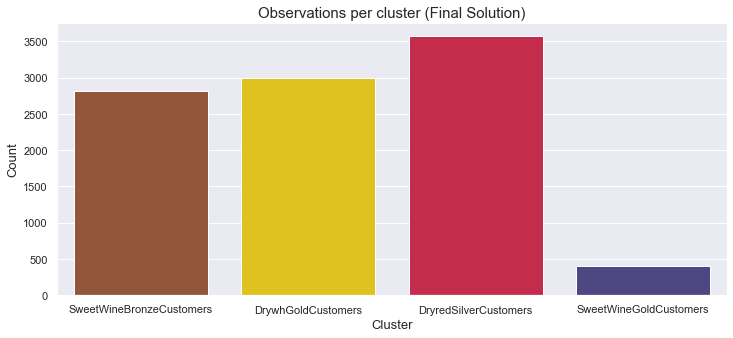

In [116]:
# observations per cluster
plt.figure(figsize=(12,5))
figure = sns.countplot(x="Names", data=visualization_df, palette=['sienna','gold','crimson', 'darkslateblue'])  
plt.xlabel('Cluster', fontsize=13)  
plt.ylabel('Count', fontsize=13) 
plt.title('Observations per cluster (Final Solution)', fontsize=15)  
plt.savefig('concatenated_finalsolutionwithoutliers.png', bbox_inches='tight') # save fig
plt.show()

In [117]:
#changing the names of the categorical variables
visualization_df.rename (columns = {'x0_18-37': 'age18-37','x0_38-57' :'age38-57', 'x0_58-78': 'age58-78', 'x1_morethan5visits':'webvisitmorethan5times',
                        'x2_above32disc': 'above32disc', 'x3_AverageAmountorless':'AverageAmountorless'}, inplace = True)

### Buying Behavior Visualization of our Final Solution

In [118]:
product_dif = visualization_df.groupby('Names').mean()

In [119]:
product_dif #final centroids 

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,age18-37,age38-57,age58-78,webvisitmorethan5times,above32disc,AverageAmountorless,cv_labels,bb_labels,merged_labels
Names,,,,,,,,,,,,,,,,,,,
DryredSilverCustomers,-0.064593,-0.029273,-0.376775,1.000861,-0.580874,-0.803307,-0.572919,-0.575812,-0.195283,0.332364,0.154989,0.700673,0.144339,0.627803,0.468610,0.521861,0.499159,2.000000,2.0
DrywhGoldCustomers,1.012566,-0.104712,1.067991,-0.225701,-0.055221,0.499921,-0.046401,-0.031956,-0.499161,-1.058194,0.009333,0.123667,0.867000,0.108000,0.030000,0.056667,1.691333,1.143333,1.0
SweetWineBronzeCustomers,-1.095379,0.172028,-0.725409,-0.885730,0.605576,0.518602,0.618497,0.622102,0.737355,0.830722,0.878248,0.119260,0.002492,0.801353,0.840869,0.959416,0.000356,0.526522,0.0
SweetWineGoldCustomers,0.675908,-0.162023,0.446210,-1.017424,1.346266,-0.226353,1.117840,1.009732,0.308327,-0.864138,0.070175,0.268170,0.661654,0.112782,0.080201,0.197995,1.411028,0.000000,3.0


In [120]:
product_dif = product_dif[['Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']]

In [121]:
product_dif.reset_index(inplace =True)

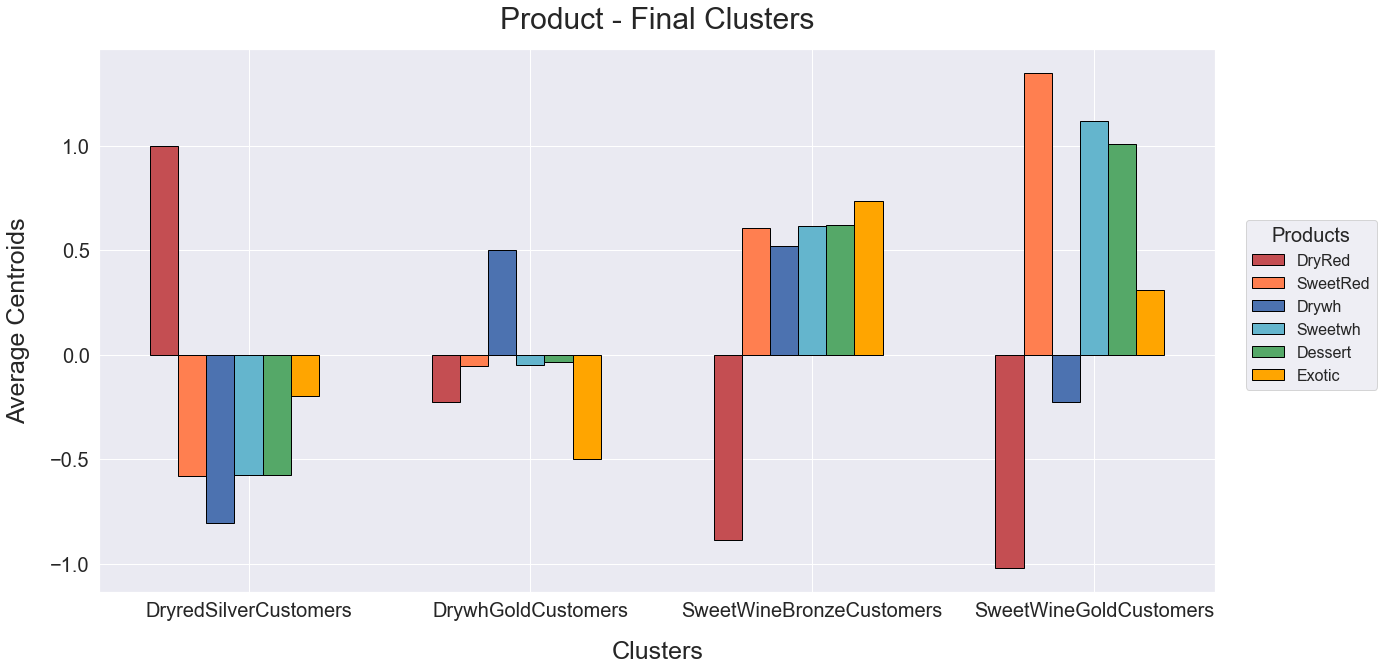

In [122]:
#create the base axis
fig, ax = plt.subplots(1,1, figsize = (20,10))
#set the labels
#and the x positions
label = product_dif['Names']
x = np.arange(len(label))
#set the width of the bars
width = 0.1
#create the first bar -1 width
rect1 = ax.bar(x - (3*width),
              product_dif['Dryred'],
              width = width, 
               label = 'DryRed',
               color = 'r', 
               edgecolor = "black"
            )

#create the second bar using x
rect2 = ax.bar(x - (2*width),
              product_dif['Sweetred'],
              width = width,
              label = 'SweetRed',
               color = 'coral', 
              edgecolor = "black")

#create the third bar plus 1 width
rects3 = ax.bar(x - width,
               product_dif['Drywh'],
               width = width,
               label = 'Drywh',
               edgecolor = "black")

rects4 = ax.bar(x,
               product_dif['Sweetwh'],
               width = width,
               label = 'Sweetwh',
                color = 'c',
               edgecolor = "black")

rects5 = ax.bar(x + width,
               product_dif['Dessert'],
               width = width,
               label = 'Dessert', 
                color = 'g',
               edgecolor = "black")


rects6 = ax.bar(x + (2*width),
               product_dif['Exotic'],
               width = width,
               label = 'Exotic',
                color = 'orange', 
               edgecolor = "black")


#add the labels to the axis
ax.set_ylabel("Average Centroids",
             fontsize = 25,
             labelpad = 20)
ax.set_xlabel("Clusters",
             fontsize = 25,
             labelpad =20)
ax.set_title("Product - Final Clusters",
            fontsize = 30,
            pad = 20)
#set the ticks
#using the labels
ax.set_xticks(x)
ax.set_xticklabels(label)
#add the legend
ax.legend(title = "Products",
         fontsize = 16,
         title_fontsize = 20,
         bbox_to_anchor = (1.02, 0.7))

#adjust the tick paramaters
ax.tick_params(axis = "x",
              which = "both",
              labelrotation = 0,
              labelsize = 20
              )

ax.tick_params(axis = "y",
              which = "both",
              labelsize = 20)

plt.savefig('Product_clusteredbarchartfinalsolution.png', bbox_inches='tight') # save fig

### Customer Value Visualization of our Final Solution

In [123]:
customer_dif = visualization_df.groupby('Names').mean()
customer_dif

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,age18-37,age38-57,age58-78,webvisitmorethan5times,above32disc,AverageAmountorless,cv_labels,bb_labels,merged_labels
Names,,,,,,,,,,,,,,,,,,,
DryredSilverCustomers,-0.064593,-0.029273,-0.376775,1.000861,-0.580874,-0.803307,-0.572919,-0.575812,-0.195283,0.332364,0.154989,0.700673,0.144339,0.627803,0.468610,0.521861,0.499159,2.000000,2.0
DrywhGoldCustomers,1.012566,-0.104712,1.067991,-0.225701,-0.055221,0.499921,-0.046401,-0.031956,-0.499161,-1.058194,0.009333,0.123667,0.867000,0.108000,0.030000,0.056667,1.691333,1.143333,1.0
SweetWineBronzeCustomers,-1.095379,0.172028,-0.725409,-0.885730,0.605576,0.518602,0.618497,0.622102,0.737355,0.830722,0.878248,0.119260,0.002492,0.801353,0.840869,0.959416,0.000356,0.526522,0.0
SweetWineGoldCustomers,0.675908,-0.162023,0.446210,-1.017424,1.346266,-0.226353,1.117840,1.009732,0.308327,-0.864138,0.070175,0.268170,0.661654,0.112782,0.080201,0.197995,1.411028,0.000000,3.0


In [124]:
customer_dif = customer_dif[['Income', 'Recency','LTV','WebPurchase']]

In [125]:
customer_dif.reset_index(inplace =True)

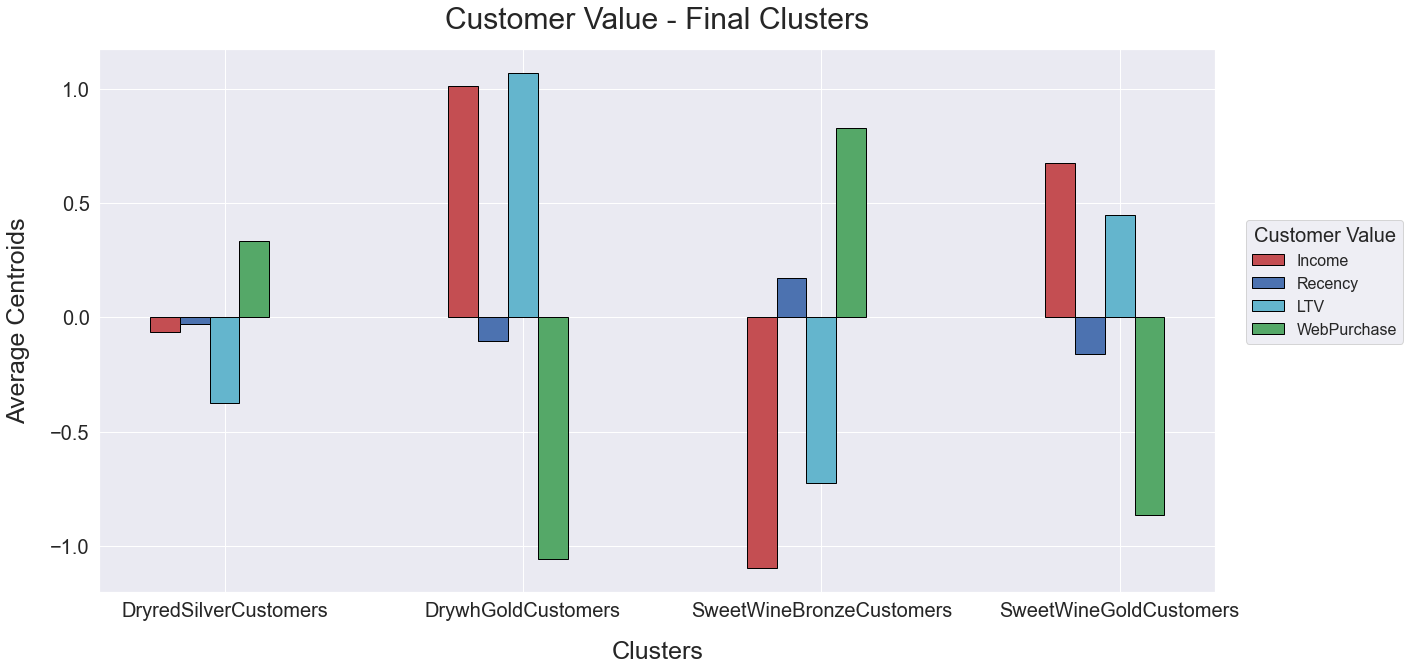

In [126]:
#create the base axis
fig, ax = plt.subplots(1,1, figsize = (20,10))
#set the labels
#and the x positions
label = customer_dif['Names']
x = np.arange(len(label))
#set the width of the bars
width = 0.1
#create the first bar -1 width

#create the second bar using x
rect1 = ax.bar(x - (2*width),
              customer_dif['Income'],
              width = width,
              label = 'Income',
               color = 'r', 
              edgecolor = "black")

#create the third bar plus 1 width
rects2 = ax.bar(x - width,
               customer_dif['Recency'],
               width = width,
               label = 'Recency',
               edgecolor = "black"
            )

rects3 = ax.bar(x,
               customer_dif['LTV'],
               width = width,
               label = 'LTV',
                color = 'c',
               edgecolor = "black"
              )

rects3 = ax.bar(x + width,
               customer_dif['WebPurchase'],
               width = width,
               label = 'WebPurchase', 
                color = 'g',
               edgecolor = "black"
               )



#add the labels to the axis
ax.set_ylabel("Average Centroids",
             fontsize = 25,
             labelpad = 20)
ax.set_xlabel("Clusters",
             fontsize = 25,
             labelpad =20)
ax.set_title("Customer Value - Final Clusters",
            fontsize = 30,
            pad = 20)
#set the ticks
#using the labels
ax.set_xticks(x)
ax.set_xticklabels(label)
#add the legend
ax.legend(title = "Customer Value",
         fontsize = 16,
         title_fontsize = 20,
         bbox_to_anchor = (1.02, 0.7))

#adjust the tick paramaters
ax.tick_params(axis = "x",
              which = "both",
              labelrotation = 0,
              labelsize = 20)

ax.tick_params(axis = "y",
              which = "both",
              labelsize = 20)

plt.savefig('CustomerValue_clusteredbarchartfinalsolution.png', bbox_inches='tight') # save fig

### Age proportion of our Final Solution

In [127]:
age = visualization_df.groupby('Names').mean()

age

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,age18-37,age38-57,age58-78,webvisitmorethan5times,above32disc,AverageAmountorless,cv_labels,bb_labels,merged_labels
Names,,,,,,,,,,,,,,,,,,,
DryredSilverCustomers,-0.064593,-0.029273,-0.376775,1.000861,-0.580874,-0.803307,-0.572919,-0.575812,-0.195283,0.332364,0.154989,0.700673,0.144339,0.627803,0.468610,0.521861,0.499159,2.000000,2.0
DrywhGoldCustomers,1.012566,-0.104712,1.067991,-0.225701,-0.055221,0.499921,-0.046401,-0.031956,-0.499161,-1.058194,0.009333,0.123667,0.867000,0.108000,0.030000,0.056667,1.691333,1.143333,1.0
SweetWineBronzeCustomers,-1.095379,0.172028,-0.725409,-0.885730,0.605576,0.518602,0.618497,0.622102,0.737355,0.830722,0.878248,0.119260,0.002492,0.801353,0.840869,0.959416,0.000356,0.526522,0.0
SweetWineGoldCustomers,0.675908,-0.162023,0.446210,-1.017424,1.346266,-0.226353,1.117840,1.009732,0.308327,-0.864138,0.070175,0.268170,0.661654,0.112782,0.080201,0.197995,1.411028,0.000000,3.0


In [128]:
age = age[['age18-37','age38-57','age58-78']]

In [129]:
age.reset_index(inplace =True)
age

,Names,age18-37,age38-57,age58-78
0,DryredSilverCustomers,0.154989,0.700673,0.144339
1,DrywhGoldCustomers,0.009333,0.123667,0.867000
2,SweetWineBronzeCustomers,0.878248,0.119260,0.002492
3,SweetWineGoldCustomers,0.070175,0.268170,0.661654


In [131]:
age

,Names,age18-37,age38-57,age58-78
0,DryredSilverCustomers,0.154989,0.700673,0.144339
1,DrywhGoldCustomers,0.009333,0.123667,0.867000
2,SweetWineBronzeCustomers,0.878248,0.119260,0.002492
3,SweetWineGoldCustomers,0.070175,0.268170,0.661654


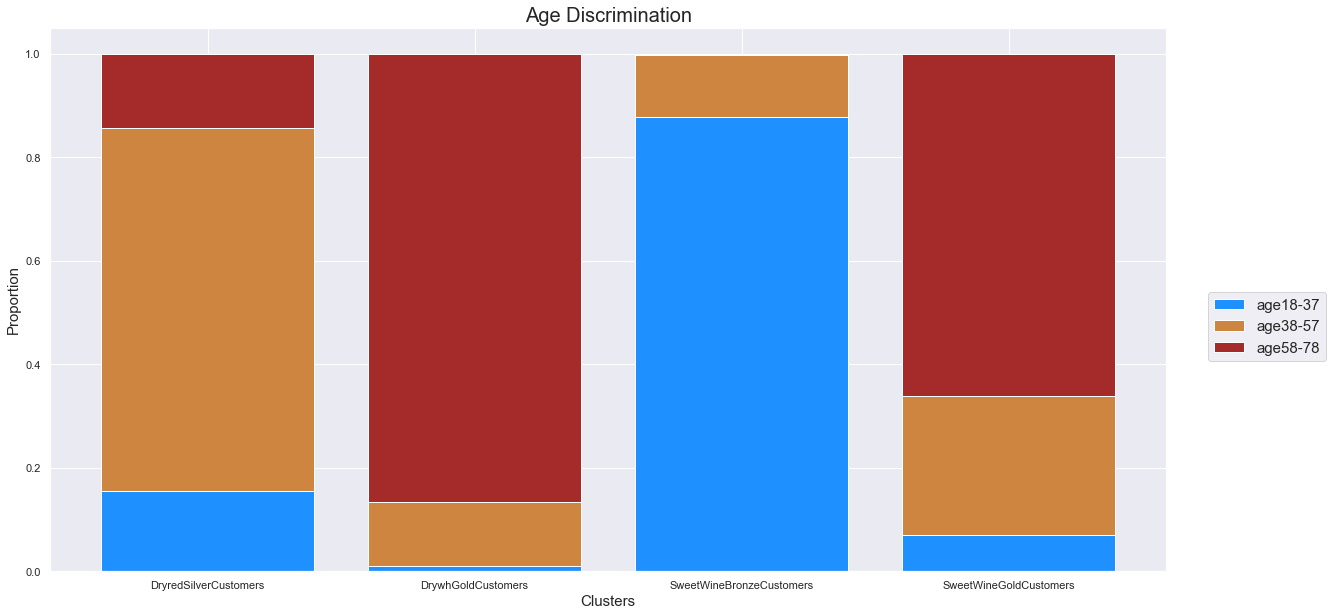

In [137]:
fig, ax = plt.subplots(1,1, figsize = (20,10))

x = age['Names'].tolist()
y1 = np.array(age['age18-37'].tolist())
y2 = np.array(age['age38-57'].tolist())
y3 = np.array(age['age58-78'].tolist())

  
# plot bars in stack manner
plt.bar(x, y1, color='dodgerblue')
plt.bar(x, y2, bottom=y1, color='peru')
plt.bar(x, y3, bottom=y1+y2, color='brown')

plt.xlabel("Clusters", fontsize = 15)
plt.ylabel("Proportion", fontsize = 15)

legend_label = age.iloc[:,1:].columns.tolist()
plt.legend(legend_label, bbox_to_anchor=([1.15, 0.45, 0., 0]), fontsize = 15, loc='center right')

plt.title("Age Discrimination", fontsize = 20)
plt.savefig('agediscrimination.png', bbox_inches='tight') # save fig
plt.show()

### Discount proportion of our Final Solution

In [138]:
discount = visualization_df.groupby('Names').mean()

discount

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,age18-37,age38-57,age58-78,webvisitmorethan5times,above32disc,AverageAmountorless,cv_labels,bb_labels,merged_labels
Names,,,,,,,,,,,,,,,,,,,
DryredSilverCustomers,-0.064593,-0.029273,-0.376775,1.000861,-0.580874,-0.803307,-0.572919,-0.575812,-0.195283,0.332364,0.154989,0.700673,0.144339,0.627803,0.468610,0.521861,0.499159,2.000000,2.0
DrywhGoldCustomers,1.012566,-0.104712,1.067991,-0.225701,-0.055221,0.499921,-0.046401,-0.031956,-0.499161,-1.058194,0.009333,0.123667,0.867000,0.108000,0.030000,0.056667,1.691333,1.143333,1.0
SweetWineBronzeCustomers,-1.095379,0.172028,-0.725409,-0.885730,0.605576,0.518602,0.618497,0.622102,0.737355,0.830722,0.878248,0.119260,0.002492,0.801353,0.840869,0.959416,0.000356,0.526522,0.0
SweetWineGoldCustomers,0.675908,-0.162023,0.446210,-1.017424,1.346266,-0.226353,1.117840,1.009732,0.308327,-0.864138,0.070175,0.268170,0.661654,0.112782,0.080201,0.197995,1.411028,0.000000,3.0


In [139]:
discount = discount[['above32disc', 'AverageAmountorless']]

In [140]:
discount['32orlessdisc'] = 1 - discount['above32disc'] 

In [141]:
discount.drop('AverageAmountorless', axis = 1, inplace = True)

In [142]:
discount.reset_index(inplace =True)
discount

,Names,above32disc,32orlessdisc
0,DryredSilverCustomers,0.468610,0.531390
1,DrywhGoldCustomers,0.030000,0.970000
2,SweetWineBronzeCustomers,0.840869,0.159131
3,SweetWineGoldCustomers,0.080201,0.919799


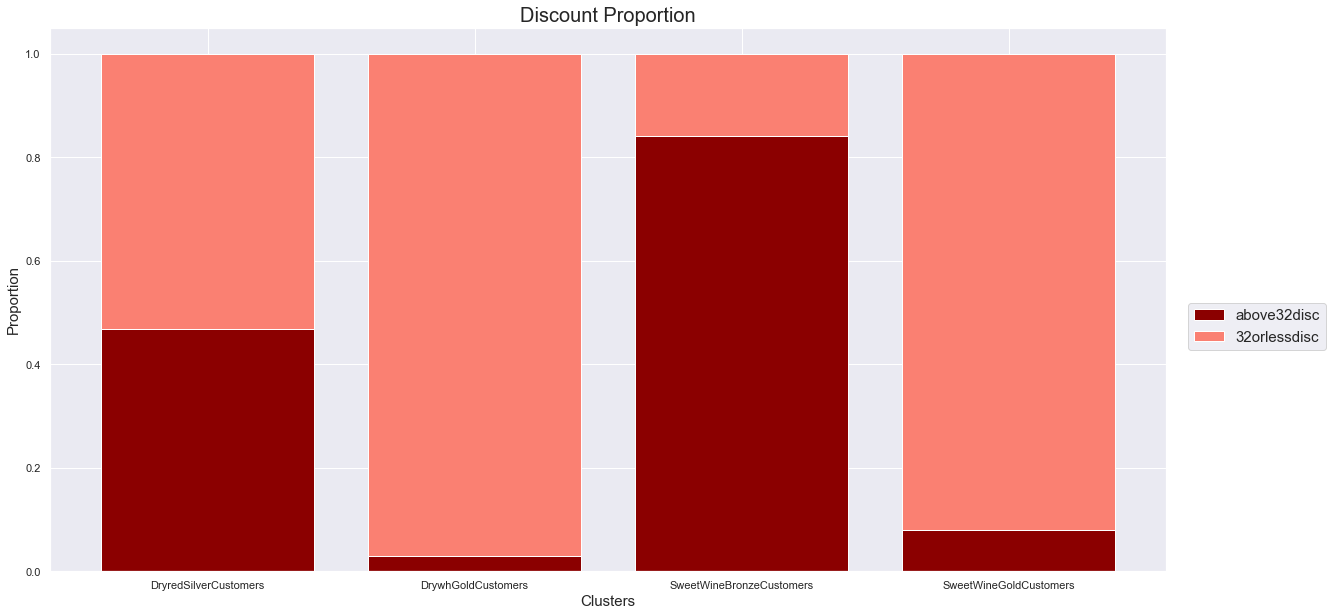

In [145]:
fig, ax = plt.subplots(1,1, figsize = (20,10))


x = age['Names'].tolist()
y1 = np.array(discount['above32disc'].tolist())
y2 = np.array(discount['32orlessdisc'].tolist())

  
# plot bars in stack manner
plt.bar(x, y1, color='darkred')
plt.bar(x, y2, bottom=y1, color='salmon')

plt.xlabel("Clusters", fontsize = 15)
plt.ylabel("Proportion", fontsize = 15)

legend_label = discount.iloc[:,1:].columns.tolist()
plt.legend(legend_label, bbox_to_anchor=([1.15, 0.45, 0., 0]), fontsize = 15, loc='center right')

plt.title("Discount Proportion", fontsize = 20)
plt.savefig('discountdiscrimination.png', bbox_inches='tight') # save fig
plt.show()

### Website Visits proportion of our Final Solution

In [146]:
webvisit = visualization_df.groupby('Names').mean()

webvisit

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,age18-37,age38-57,age58-78,webvisitmorethan5times,above32disc,AverageAmountorless,cv_labels,bb_labels,merged_labels
Names,,,,,,,,,,,,,,,,,,,
DryredSilverCustomers,-0.064593,-0.029273,-0.376775,1.000861,-0.580874,-0.803307,-0.572919,-0.575812,-0.195283,0.332364,0.154989,0.700673,0.144339,0.627803,0.468610,0.521861,0.499159,2.000000,2.0
DrywhGoldCustomers,1.012566,-0.104712,1.067991,-0.225701,-0.055221,0.499921,-0.046401,-0.031956,-0.499161,-1.058194,0.009333,0.123667,0.867000,0.108000,0.030000,0.056667,1.691333,1.143333,1.0
SweetWineBronzeCustomers,-1.095379,0.172028,-0.725409,-0.885730,0.605576,0.518602,0.618497,0.622102,0.737355,0.830722,0.878248,0.119260,0.002492,0.801353,0.840869,0.959416,0.000356,0.526522,0.0
SweetWineGoldCustomers,0.675908,-0.162023,0.446210,-1.017424,1.346266,-0.226353,1.117840,1.009732,0.308327,-0.864138,0.070175,0.268170,0.661654,0.112782,0.080201,0.197995,1.411028,0.000000,3.0


In [147]:
webvisit = webvisit[['webvisitmorethan5times', 'AverageAmountorless']]

In [148]:
webvisit['webvisit5timesorless'] = 1 - webvisit['webvisitmorethan5times'] 

In [149]:
webvisit.drop('AverageAmountorless', axis = 1, inplace = True)

In [150]:
webvisit.reset_index(inplace =True)
webvisit

,Names,webvisitmorethan5times,webvisit5timesorless
0,DryredSilverCustomers,0.627803,0.372197
1,DrywhGoldCustomers,0.108000,0.892000
2,SweetWineBronzeCustomers,0.801353,0.198647
3,SweetWineGoldCustomers,0.112782,0.887218


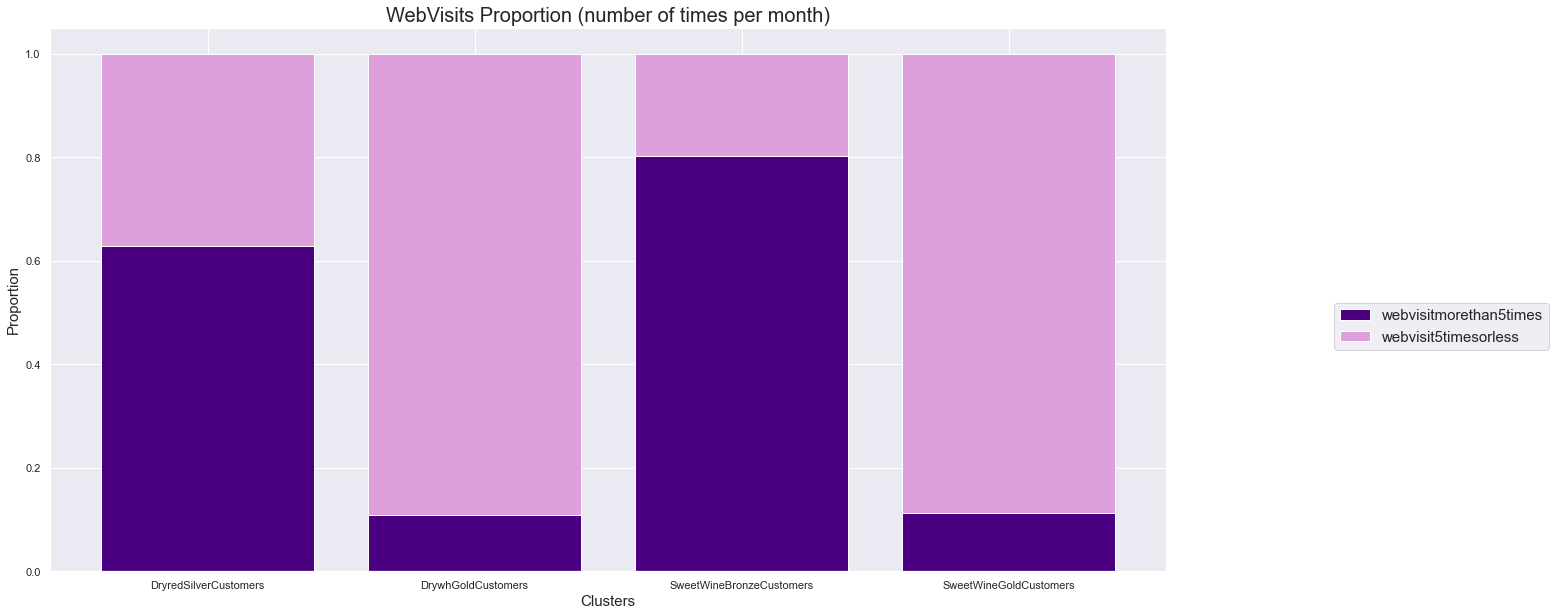

In [152]:
fig, ax = plt.subplots(1,1, figsize = (20,10))


x = age['Names'].tolist()
y1 = np.array(webvisit['webvisitmorethan5times'].tolist())
y2 = np.array(webvisit['webvisit5timesorless'].tolist())

  
# plot bars in stack manner
plt.bar(x, y1, color='indigo')
plt.bar(x, y2, bottom=y1, color='plum')

plt.xlabel("Clusters", fontsize = 15)
plt.ylabel("Proportion", fontsize = 15)

legend_label = webvisit.iloc[:,1:].columns.tolist()
plt.legend(legend_label, bbox_to_anchor=([1.35, 0.45, 0., 0]), fontsize = 15, loc='center right')

plt.title("WebVisits Proportion (number of times per month)", fontsize = 20)
plt.savefig('webvisitdiscrimination.png', bbox_inches='tight') # save fig
plt.show()

### Average Amount spent per Visit (last 18 months) of our Final Solution

In [153]:
amount = visualization_df.groupby('Names').mean()

amount

,Income,Recency,LTV,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,age18-37,age38-57,age58-78,webvisitmorethan5times,above32disc,AverageAmountorless,cv_labels,bb_labels,merged_labels
Names,,,,,,,,,,,,,,,,,,,
DryredSilverCustomers,-0.064593,-0.029273,-0.376775,1.000861,-0.580874,-0.803307,-0.572919,-0.575812,-0.195283,0.332364,0.154989,0.700673,0.144339,0.627803,0.468610,0.521861,0.499159,2.000000,2.0
DrywhGoldCustomers,1.012566,-0.104712,1.067991,-0.225701,-0.055221,0.499921,-0.046401,-0.031956,-0.499161,-1.058194,0.009333,0.123667,0.867000,0.108000,0.030000,0.056667,1.691333,1.143333,1.0
SweetWineBronzeCustomers,-1.095379,0.172028,-0.725409,-0.885730,0.605576,0.518602,0.618497,0.622102,0.737355,0.830722,0.878248,0.119260,0.002492,0.801353,0.840869,0.959416,0.000356,0.526522,0.0
SweetWineGoldCustomers,0.675908,-0.162023,0.446210,-1.017424,1.346266,-0.226353,1.117840,1.009732,0.308327,-0.864138,0.070175,0.268170,0.661654,0.112782,0.080201,0.197995,1.411028,0.000000,3.0


In [154]:
amount = amount[['above32disc', 'AverageAmountorless']]

In [155]:
amount['AboveAverageAmount'] = 1 - amount['AverageAmountorless'] 

In [156]:
amount.drop('above32disc', axis = 1, inplace = True)

In [157]:
amount.reset_index(inplace =True)
amount

,Names,AverageAmountorless,AboveAverageAmount
0,DryredSilverCustomers,0.521861,0.478139
1,DrywhGoldCustomers,0.056667,0.943333
2,SweetWineBronzeCustomers,0.959416,0.040584
3,SweetWineGoldCustomers,0.197995,0.802005


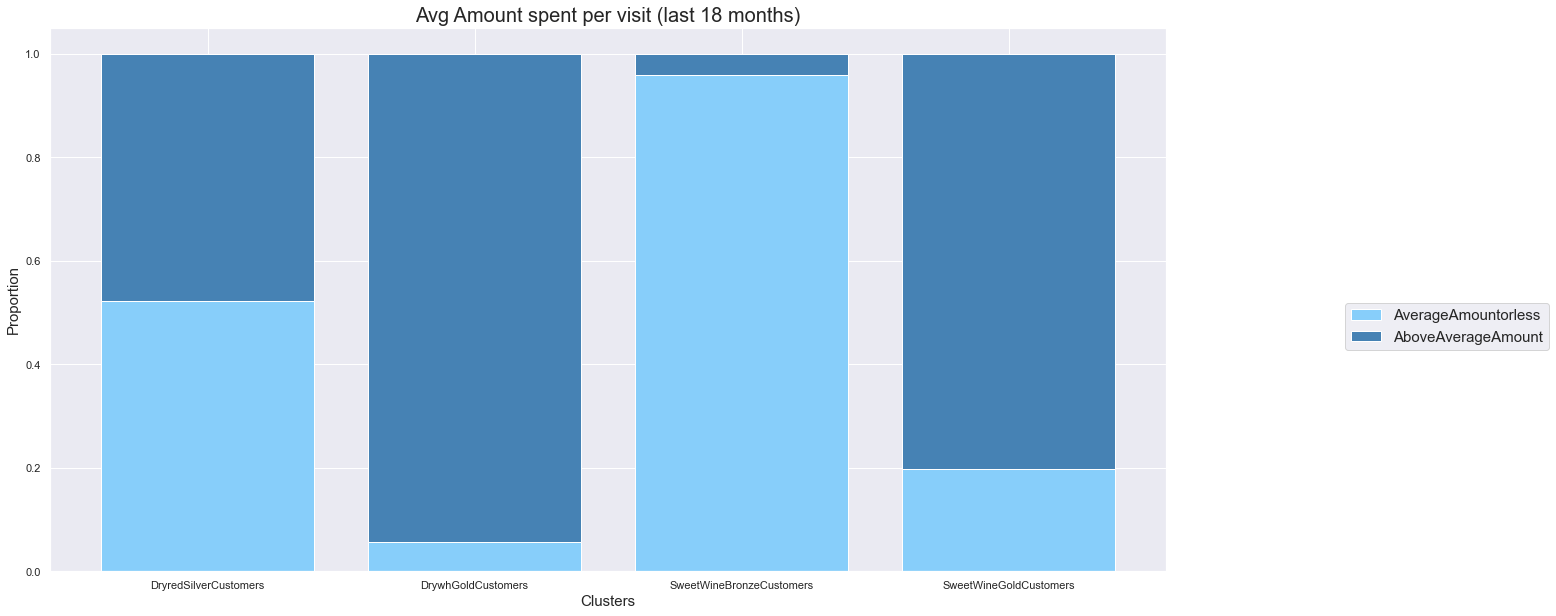

In [159]:
fig, ax = plt.subplots(1,1, figsize = (20,10))


x = age['Names'].tolist()
y1 = np.array(amount['AverageAmountorless'].tolist())
y2 = np.array(amount['AboveAverageAmount'].tolist())

  
# plot bars in stack manner
plt.bar(x, y1, color='lightskyblue')
plt.bar(x, y2, bottom=y1, color='steelblue')

plt.xlabel("Clusters", fontsize = 15)
plt.ylabel("Proportion", fontsize = 15)

legend_label = amount.iloc[:,1:].columns.tolist()
plt.legend(legend_label, bbox_to_anchor=([1.35, 0.45, 0., 0]), fontsize = 15, loc='center right')

plt.title("Avg Amount spent per visit (last 18 months)", fontsize = 20)
plt.savefig('avgamountdiscrimination.png', bbox_inches='tight') # save fig
plt.show()